In [1]:
### THE ENTIRE NOTEBOOK NEEDS TO BE UPDATED TO NEW NOTATION. 
# To convert:
# a=gamma, alpha_a=a, alpha_b=b, h removed, d=tilde_q
# c_hat expressed in terms of g, delta expressed in terms of c or c_hat

In [2]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from labellines import labelLine, labelLines  # will first need to install labellines package
from matplotlib.pyplot import cm

seedno = 12345
rng = np.random.default_rng(seed=seedno)

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"
# font size for labels in plots
fs = 15
dpi = 300
# Will fix figure size for this notebook
plt.rcParams["figure.figsize"] = (8,6)

## Model parameters

In [4]:
sigma = 1
S0 = 100.

T = 1.
lambda_a = 10.
lambda_b = 10.  

qmax = 10
qmin = -qmax
sigma_Z = 1.
kappa = 2.
# Model for misses
eta = 0.01 # TICK SIZE
a = 0.1
b = 0.1
beta = 0.05

# Penalties
phi = 0.1
gamma = 0.03

# changes font in plots
fontnm = "Times New Roman" 
tnrfont = {'fontname':fontnm} 

In [5]:
all_inventories = np.arange(qmax, qmin-1, step = -1)

## Implementation

In [6]:
def _calculate_omega_t(t):
    A_matrix = np.zeros((2*qmax+1,2*qmax+1))
    vector = np.zeros((2*qmax+1,1))
    for i in range(2*qmax+1):
        inventory = qmax - i
        A_matrix[i, i] = - phi * kappa * inventory**2 + beta * kappa * (lambda_a - lambda_b) * inventory
        vector[i, 0] = np.exp(kappa * ((a-b)/2)*inventory - (gamma - beta/2)*inventory**2)
        if i + 1 < (2*qmax+1):
            A_matrix[i, i + 1] = lambda_b * np.exp(-1.+kappa*b - kappa*beta/2) 
        if i > 0:
            A_matrix[i, i - 1] = lambda_a * np.exp(-1.+kappa*a - kappa*beta/2) 
    return np.matmul(expm(A_matrix*(T-t) ), vector)

In [7]:
def _calculate_gt(t):
    omega_function = _calculate_omega_t(t)
    return (1 / kappa) * np.log(omega_function)

In [8]:
def _calculate_deltas(t, q, q_tilde, z, take_maximum = True):    
    
    g_qs = _calculate_gt(t)
    
    indices = np.clip(qmax - q, 0, 2 * qmax)
    indices = indices.astype(int)
    indices_minus_one = np.clip(indices + 1, 0, 2 * qmax)  # moving up an index corresponds to lower inventory
    indices_plus_one = np.clip(indices - 1, 0, 2 * qmax) # moving down an index corresponds to higher inventory

    c_hat_a = 1/kappa - np.squeeze(g_qs[indices_minus_one]) + np.squeeze(g_qs[indices])
    c_hat_b = 1/kappa - np.squeeze(g_qs[indices_plus_one]) + np.squeeze(g_qs[indices])
    
    if take_maximum:
        c_a = np.maximum(c_hat_a, a - beta/2)
        c_b = np.maximum(c_hat_b, b - beta/2)
    else:
        c_a = c_hat_a
        c_b = c_hat_b
    
    delta_a = c_a - beta*q_tilde - z + beta/2
    delta_b = c_b + beta*q_tilde + z + beta/2

    return delta_a, delta_b
    

# Numerics

In [9]:
t = 0.5
z = 0

q_vector = np.arange(qmax-1,qmin,step=-1)
q_tilde_vector = np.arange(10-1,-10,step=-1)

deltas_a = np.zeros((len(q_vector), len(q_tilde_vector)))
deltas_b = np.zeros((len(q_vector), len(q_tilde_vector)))

for j,q_tilde in enumerate(q_tilde_vector):
    for i,q in enumerate(q_vector):
        delta_a, delta_b = _calculate_deltas(t, q, q_tilde, z, take_maximum=False)
        deltas_a[i, j] = delta_a
        deltas_b[i, j] = delta_b

In [10]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from labellines import labelLines  # Assuming labelLines is imported from somewhere

cmap = plt.get_cmap("viridis")

norm = Normalize(vmin=min(q_vector), vmax=max(q_vector))
sm = ScalarMappable(norm=norm, cmap=cmap)

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (6,4), sharey=False, sharex=True)

for i, q in enumerate(q_tilde_vector):
    color = cmap(norm(q_tilde_vector[i]))
    ax.plot(q_vector, deltas_a[:,i], '-', color=color, alpha=0.6)
    ax.plot(q_vector, deltas_b[:,i], '--', color=color, alpha=0.6)

# Add grid, labels, and ticks
plt.grid(alpha=0.3)
plt.xlabel(r'$Q_t$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$\hat\delta^{a}_t, \hat\delta^{b}_t$', fontsize=fs)

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label(r'$\tilde{Q}_t$', fontsize=fs)

plt.tight_layout()
plt.savefig('figures/approxoptdepths.pdf', format="pdf", dpi=dpi)

plt.show()

<Figure size 600x400 with 2 Axes>

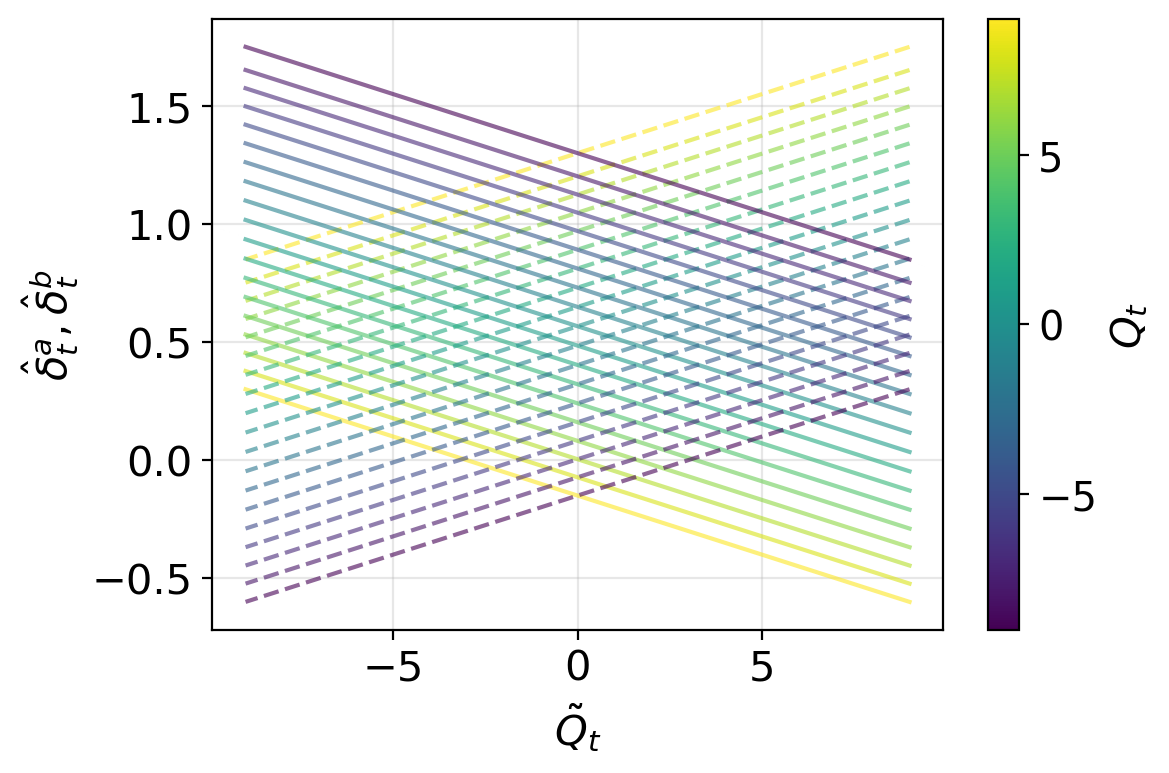

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (6,4), sharey=False, sharex=True)

for i, q in enumerate(q_vector):
    color = cmap(norm(q_vector[i]))
    ax.plot(q_tilde_vector, deltas_a[i,:], '-', color=color, alpha=0.6)
    ax.plot(q_tilde_vector, deltas_b[i,:], '--', color=color, alpha=0.6)

# Add grid, labels, and ticks
plt.grid(alpha=0.3)
plt.xlabel(r'$\tilde{Q}_t$', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$\hat\delta^{a}_t, \hat\delta^{b}_t$', fontsize=fs)

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label(r'${Q}_t$', fontsize=fs)

plt.tight_layout()
plt.savefig('figures/approxoptdepths_v2.pdf', format="pdf", dpi=dpi)

plt.show()

In [13]:
t = 0.5
q = 0
z = 0
q_tildemax = 5
q_tildemin = - q_tildemax

q_tilde_vector = np.arange(q_tildemax-1,q_tildemin,step=-1)

deltas_a = np.zeros((q_tilde_vector.shape))
deltas_b = np.zeros((q_tilde_vector.shape))

for i,q_tilde in enumerate(q_tilde_vector):
    delta_a, delta_b = _calculate_deltas(t, q, q_tilde, z, take_maximum=False)
    deltas_a[i] = delta_a
    deltas_b[i] = delta_b

In [14]:
t_vector = np.linspace(0,T,num=100)
q_vector = np.arange(qmax-1,qmin,step=-1)

q_tilde = 0
z = 0

deltas_a = np.zeros((t_vector.shape[0],q_vector.shape[0]))
deltas_b = np.zeros((t_vector.shape[0],q_vector.shape[0]))

for it,t in enumerate(t_vector):
    for iq,q in enumerate(q_vector):
        delta_a, delta_b = _calculate_deltas(t, q, q_tilde, z, take_maximum = False)
        deltas_a[it,iq] = delta_a
        deltas_b[it,iq] = delta_b

In [15]:
cmap = plt.get_cmap("viridis")

norm = Normalize(vmin=min(q_vector), vmax=max(q_vector))
sm = ScalarMappable(norm=norm, cmap=cmap)

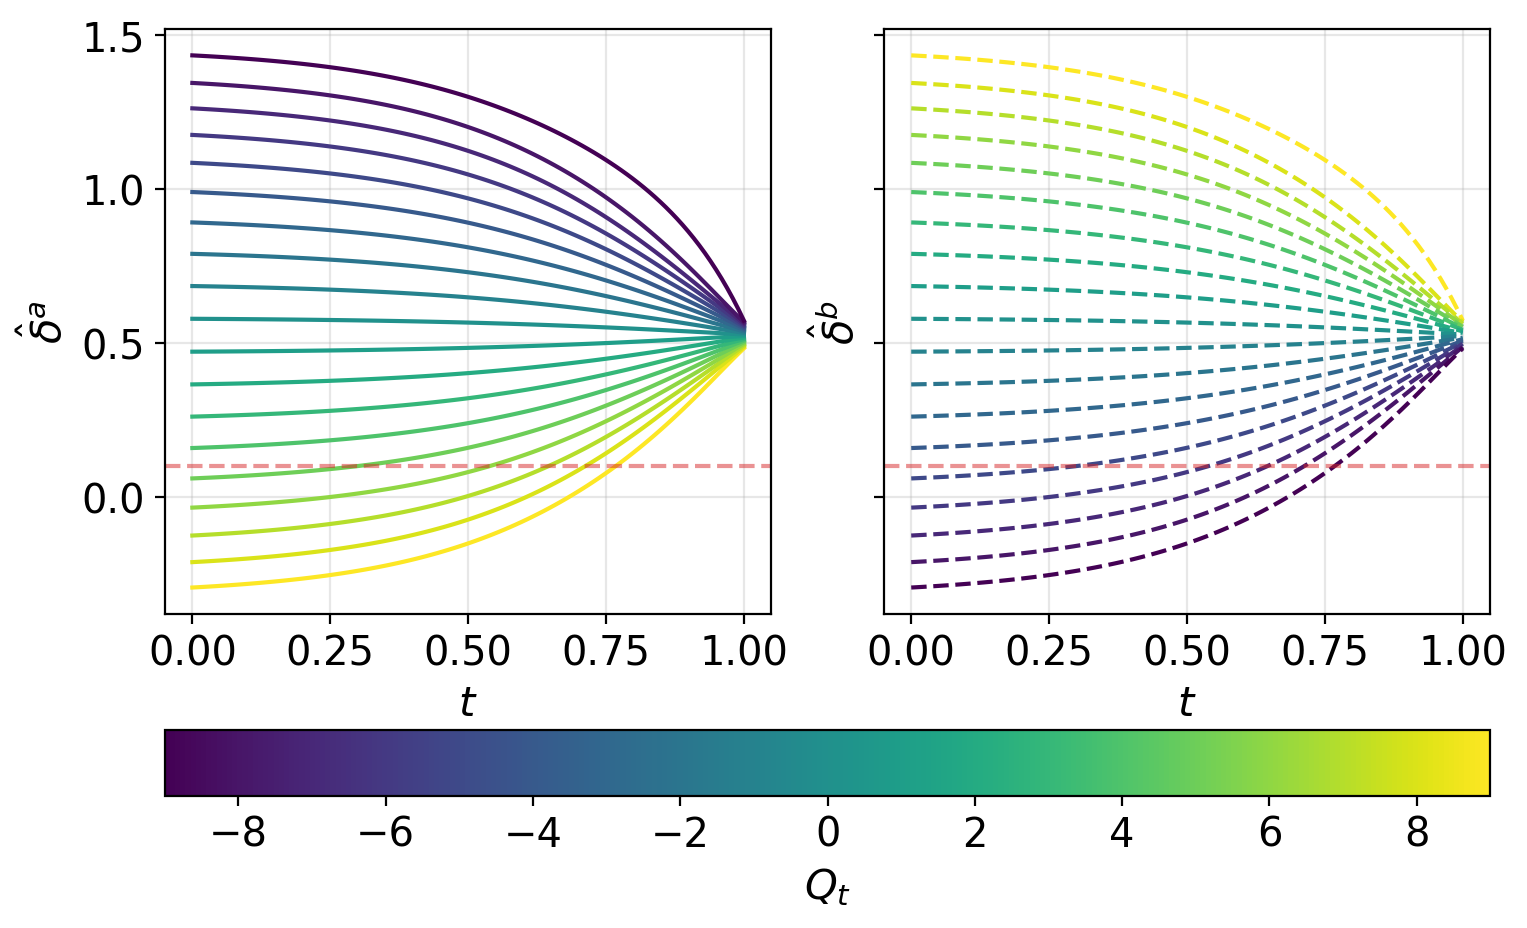

In [16]:
#colors = cm.rainbow(np.linspace(0.6, 1, len(q_vector)))


fig, ax = plt.subplots(1,2, figsize = (8,5), sharey=True)
for iq,q in enumerate(q_vector):
    color = cmap(norm(q_vector[iq]))
    if q<3:
        ax[0].plot(t_vector, deltas_a[:,iq],'-', color = color)#, label="q="+str(q), colors[iq])
    else:
        ax[0].plot(t_vector, deltas_a[:,iq],'-', color = color) #colors[iq])
for iq,q in enumerate(q_vector):
    color = cmap(norm(q_vector[iq]))
    if q>-3:
        ax[1].plot(t_vector, deltas_b[:,iq],'--', color = color) #, label="q="+str(q), colors[iq])
    else:
        ax[1].plot(t_vector, deltas_b[:,iq],'--', color = color) # label=" ", colors[iq])
        
ax[0].axhline(y = a, xmin=0, xmax=1, linestyle='--', color = 'tab:red', alpha = 0.5)
ax[1].axhline(y = a, xmin=0, xmax=1, linestyle='--', color = 'tab:red', alpha = 0.5)

        
ax[0].set_xlabel(r'$t$', fontsize = fs)
ax[1].set_xlabel(r'$t$', fontsize = fs)
ax[0].set_ylabel(r'$\hat\delta^{a}$', fontsize = fs)
ax[1].set_ylabel(r'$\hat\delta^{b}$', fontsize = fs)
#labelLines(ax[0].get_lines(), zorder=2.5)
#labelLines(ax[1].get_lines(), zorder=2.5)
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)

plt.tight_layout()

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.14)
cbar.set_label(r'$Q_t$', fontsize=fs)

#plt.tight_layout()


#cbar = fig.colorbar(sm, ax=ax[1], orientation='vertical')

#cbar.set_label(r'$\tilde{Q}_t$', fontsize=fs)
plt.savefig('figures/delta_through_time_fct_of_Q_t.pdf', format="pdf", dpi=dpi)
plt.show()

# ********************

# ********************

# Experiments

# ********************

# ********************

In [17]:
def brownian(Nt=1000, S0=0, sigma=0.01):
    timesteps = np.linspace(0, T, Nt)
    path = np.zeros(Nt)
    path[0] = S0
    Z = rng.normal(0,1, Nt)
    for n in range(1, Nt):
        path[n] = path[n-1] + sigma * np.sqrt(T/Nt) * Z[n]
    return path

def get_arrival(sims, dt, lambda_a, lambda_b):
    unif_a = rng.uniform(size=(sims,))
    unif_b = rng.uniform(size=(sims,))
    return unif_a < 1. - np.exp(-lambda_a * dt), unif_b < 1. - np.exp(-lambda_b * dt)

In [18]:
Nt = 1000
sims = 10_000
dt = T/Nt

X = np.zeros((sims,Nt+1))
Q = np.zeros((sims,Nt+1))
Q_tilde = np.zeros((sims,Nt+1))
S = np.zeros((sims,Nt+1))
Z = np.zeros((sims,Nt+1))
pnl = np.zeros(sims)
intQ = np.zeros(sims)
objective = np.zeros(sims)

deltas_a = np.zeros((sims, Nt+1))
deltas_b = np.zeros((sims, Nt+1))
tildes_a = np.zeros((sims, Nt+1))
tildes_b = np.zeros((sims, Nt+1))

arrivaltimes_a = np.zeros((sims, Nt+1))
arrivaltimes_b = np.zeros((sims, Nt+1))

S[:,0] = S0

time = np.linspace(0, T, Nt+1)

In [19]:
for it,t in enumerate(time[:-1]):   
    delta_a, delta_b = _calculate_deltas(t, Q[:,it], Q_tilde[:,it], Z[:,it])
    deltas_a[:, it] = delta_a[:]
    deltas_b[:, it] = delta_b[:]
    
    aux_normal = rng.normal(0, 1, size= (sims,))
    Z[:,it+1] = Z[:,it] + sigma_Z * np.sqrt(T/Nt) * aux_normal

    aux_normal = rng.normal(0, 1, size= (sims,))
    S[:,it+1] = S[:,it] + sigma *  np.sqrt(T/Nt) * aux_normal
    
    arrival_a, arrival_b = get_arrival(sims, dt, lambda_a, lambda_b)
    arrivaltimes_a[:,it] = arrival_a*t
    arrivaltimes_b[:,it] = arrival_b*t
    
    fill_a = rng.uniform(size=(sims,))
    fill_b = rng.uniform(size=(sims,))
    
    delta_tilde_a = a - beta * Q_tilde[:,it] - Z[:,it]
    delta_tilde_b = b + beta * Q_tilde[:,it] + Z[:,it]
    tildes_a[:,it] = delta_tilde_a[:]
    tildes_b[:,it] = delta_tilde_b[:]
    
    prob_a = np.minimum(np.exp(-kappa*(delta_a - delta_tilde_a)),1)
    prob_b = np.minimum(np.exp(-kappa*(delta_b - delta_tilde_b)),1)
    
    
    filled_trade_a = (fill_a <= prob_a) * (Q[:,it]!=(qmin+1))
    filled_trade_b = (fill_b <= prob_b) * (Q[:,it]!=(qmax-1))
    
    
    Q[:,it+1] = Q[:,it] - filled_trade_a*arrival_a + filled_trade_b*arrival_b
    Q_tilde[:,it+1] = Q_tilde[:,it] - (1-filled_trade_a)*arrival_a + (1-filled_trade_b)*arrival_b
    
    X[:,it+1] = X[:,it] + filled_trade_a*arrival_a*(S[:,it] + delta_a) - filled_trade_b*arrival_b*(S[:,it] - delta_b)
        
        
    
pnl[:] = X[:,-1] + Q[:,-1]*(S[:,-1]+(a-b)/2 - beta*Q_tilde[:,-1] - Z[:,-1])
for s in range(1, sims):
    intQ[s] = np.sum(Q[s,:]**2)/Nt
objective[:] = pnl[:] - a*Q[:,-1]**2 - phi*intQ[:] 


Terminal Q mean = -0.0069              Terminal Q sd = 2.0037
Terminal $	ilde{Q}$ mean = -0.0439              Terminal $	ilde{Q}$ sd = 3.62
Terminal X mean = 5.0532            Terminal X sd = 200.4288
Terminal PnL mean = 4.2632           Terminal PnL sd = 2.5367
Terminal objective mean = 3.6362     Terminal objective sd = 2.5693
$Q_{T}$ &-0.0069 & 2.0037 \\ 
$	ilde{Q}_{T}$ &-0.0439 & 3.62 \\ 
$\mathcal{J}$ &3.6362 & 2.5693 \\ 


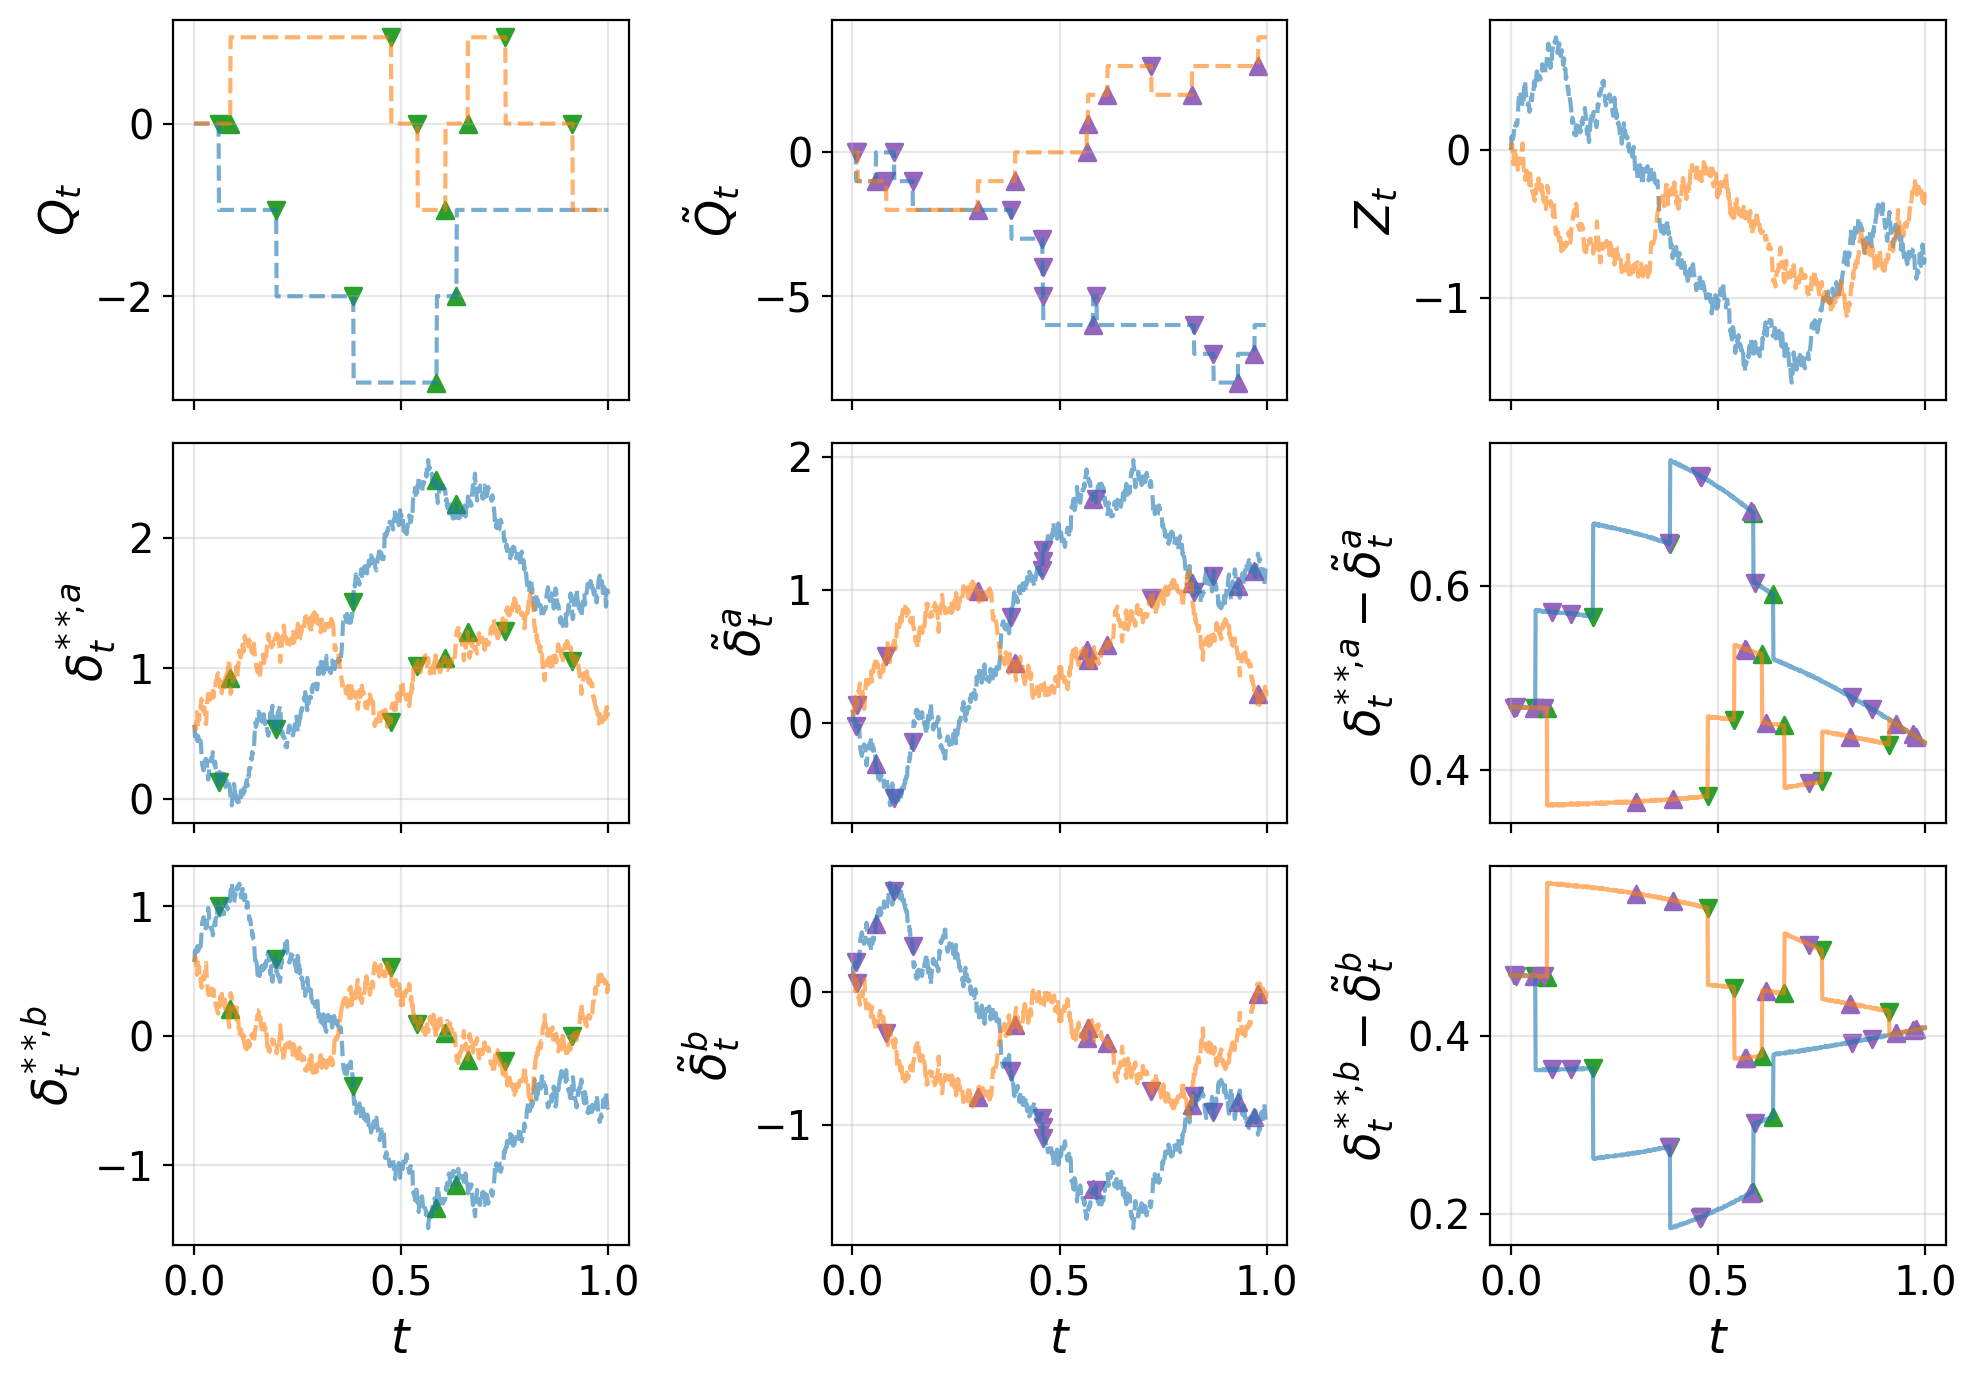

In [52]:
# since final depths never calculated
nmin = 7
nmax = nmin + 2
deltas_a[:,-1] = deltas_a[:,-2]
deltas_b[:,-1] = deltas_b[:,-2]
tildes_a[:,-1] = tildes_a[:,-2]
tildes_b[:,-1] = tildes_b[:,-2]

print("Terminal Q mean = "+str(np.round(np.mean(Q[:,-1]),4))+"              Terminal Q sd = "+str(np.round(np.std(Q[:,-1]),4)))
print("Terminal $\tilde{Q}$ mean = "+str(np.round(np.mean(Q_tilde[:,-1]),4))+"              Terminal $\tilde{Q}$ sd = "+str(np.round(np.std(Q_tilde[:,-1]),4)))
print("Terminal X mean = "+str(np.round(np.mean(X[:,-1]),4))+"            Terminal X sd = "+str(np.round(np.std(X[:,-1]),4)))
print("Terminal PnL mean = "+str(np.round(np.mean(pnl[:]),4))+"           Terminal PnL sd = "+str(np.round(np.std(pnl[:]),4)))
print("Terminal objective mean = "+str(np.round(np.mean(objective[:]),4))+"     Terminal objective sd = "+str(np.round(np.std(objective[:]),4)))

print("$Q_{T}$ &"+str(np.round(np.mean(Q[:,-1]),4))+" & "+str(np.round(np.std(Q[:,-1]),4))+" \\\ ")
print("$\tilde{Q}_{T}$ &"+str(np.round(np.mean(Q_tilde[:,-1]),4))+" & "+str(np.round(np.std(Q_tilde[:,-1]),4))+" \\\ ") 
print("$\mathcal{J}$ &"+str(np.round(np.mean(objective[:]),4))+" & "+str(np.round(np.std(objective[:]),4))+" \\\ ")



fig, ax = plt.subplots(3, 3, figsize = (10,7), sharey=False, sharex=True)
ax[0,0].plot(time, np.transpose(Q[nmin:nmax,:]), '--', alpha = 0.6)

#ax[0,0].plot(time, np.repeat(qmax, len(time)), 'k--', alpha = 0.6)
#ax[0,0].plot(time, np.repeat(qmin, len(time)), 'k--', alpha = 0.6)
ax[0,1].plot(time, np.transpose(Q_tilde[nmin:nmax,:]), '--', alpha = 0.6)
ax[0,2].plot(time, np.transpose(Z[nmin:nmax,:]), '--', alpha = 0.6)


ax[1,0].plot(time, np.transpose(deltas_a[nmin:nmax,:]), linestyle= '--', label=r'$\delta^{a}$', alpha = 0.6)
ax[1,1].plot(time, np.transpose(tildes_a[nmin:nmax,:]), '--', label=r'$\tilde{\delta}^{a}$', alpha = 0.6)
ax[1,2].plot(time, np.transpose(deltas_a[nmin:nmax,:]-tildes_a[nmin:nmax,:]), label='Reference spread', alpha = 0.6)

ax[2,0].plot(time, np.transpose(deltas_b[nmin:nmax,:]), '--', label=r'$\delta^{b}$', alpha = 0.6)
ax[2,1].plot(time, np.transpose(tildes_b[nmin:nmax,:]), '--', label=r'$\tilde{\delta}^{a}$', alpha = 0.6)
ax[2,2].plot(time, np.transpose(np.round(deltas_b[nmin:nmax,:]-tildes_b[nmin:nmax,:],3)), label='Competition spread', alpha = 0.6)

transp = 1.
for i in np.arange(nmin,nmax,1):
    
    mm_bought = np.argwhere(np.diff(Q[i,:])==1)[:,0]
    mm_sold = np.argwhere(np.diff(Q[i,:])==-1)[:,0]
    ax[0,0].scatter(time[mm_sold], Q[i,mm_sold], marker = "v", color='tab:green', alpha = transp)
    ax[0,0].scatter(time[mm_bought], Q[i,mm_bought], marker = "^", color='tab:green', alpha = transp)
   
    ax[1,0].scatter(time[mm_sold], deltas_a[i,mm_sold], marker = "v", color='tab:green', alpha = transp)
    ax[1,0].scatter(time[mm_bought], deltas_a[i,mm_bought], marker = "^", color='tab:green', alpha = transp)

    ax[2,0].scatter(time[mm_sold], deltas_b[i,mm_sold], marker = "v", color='tab:green', alpha = transp)
    ax[2,0].scatter(time[mm_bought], deltas_b[i,mm_bought], marker = "^", color='tab:green', alpha = transp)
    
    ax[1,2].scatter(time[mm_sold], deltas_a[i,mm_sold]-tildes_a[i,mm_sold], marker = "v", color='tab:green', alpha = transp)
    ax[1,2].scatter(time[mm_bought], deltas_a[i,mm_bought]-tildes_a[i,mm_bought], marker = "^", color='tab:green', alpha = transp)
    
    ax[2,2].scatter(time[mm_sold], deltas_b[i,mm_sold]-tildes_b[i,mm_sold], marker = "v", color='tab:green', alpha = transp)
    ax[2,2].scatter(time[mm_bought], deltas_b[i,mm_bought]-tildes_b[i,mm_bought], marker = "^", color='tab:green', alpha = transp)
    
    comp_bought = np.argwhere(np.diff(Q_tilde[i,:])==1)[:,0]
    comp_sold = np.argwhere(np.diff(Q_tilde[i,:])==-1)[:,0]
    
    ax[0,1].scatter(time[comp_bought], Q_tilde[i,comp_bought], marker = "^", color='tab:purple', alpha = transp)
    ax[0,1].scatter(time[comp_sold], Q_tilde[i,comp_sold], marker = "v", color='tab:purple', alpha = transp)
    
    ax[1,1].scatter(time[comp_bought], tildes_a[i,comp_bought], marker = "^", color='tab:purple', alpha = transp)
    ax[1,1].scatter(time[comp_sold], tildes_a[i,comp_sold], marker = "v", color='tab:purple', alpha = transp)
    
    ax[2,1].scatter(time[comp_bought], tildes_b[i,comp_bought], marker = "^", color='tab:purple', alpha = transp)
    ax[2,1].scatter(time[comp_sold], tildes_b[i,comp_sold], marker = "v", color='tab:purple', alpha = transp)
    
    ax[1,2].scatter(time[comp_bought], deltas_a[i,comp_bought]-tildes_a[i,comp_bought], marker = "^", color='tab:purple', alpha = transp)
    ax[1,2].scatter(time[comp_sold], deltas_a[i,comp_sold]-tildes_a[i,comp_sold], marker = "v", color='tab:purple', alpha = transp)

    
    ax[2,2].scatter(time[comp_bought], deltas_b[i,comp_bought]-tildes_b[i,comp_bought], marker = "^", color='tab:purple', alpha = transp)
    ax[2,2].scatter(time[comp_sold], deltas_b[i,comp_sold]-tildes_b[i,comp_sold], marker = "v", color='tab:purple', alpha = transp)


    

#ax[0].set_title("Reference MM's inventory", **tnrfont)
#ax[1].set_title("Pooled competition's inventory", **tnrfont)
ax[2,0].set_xlabel(r'$t$', fontsize = fs)
ax[2,1].set_xlabel(r'$t$', fontsize = fs)
ax[2,2].set_xlabel(r'$t$', fontsize = fs)

ax[0,0].set_ylabel(r'$Q_t$', fontsize = fs)
ax[0,1].set_ylabel(r'$\tilde{Q}_t$', fontsize = fs)
ax[0,2].set_ylabel(r'$Z_t$', fontsize = fs)

ax[1,0].set_ylabel(r'$\delta^{**\!\!,\!a}_t$', fontsize = fs)
ax[1,1].set_ylabel(r'$\tilde\delta^{a}_t$', fontsize = fs)
ax[1,2].set_ylabel(r'$\delta^{**\!\!,\!a}_t-\tilde\delta^{a}_t$', fontsize = fs)

ax[2,0].set_ylabel(r'${\delta}^{**\!\!,\!b}_t$', fontsize = fs)
ax[2,1].set_ylabel(r'$\tilde{\delta}^{b}_t$', fontsize = fs)
ax[2,2].set_ylabel(r'${\delta}^{**\!\!,\!b}_t-\tilde{\delta}^{b}_t$', fontsize = fs)

plt.tight_layout()

for i in range(3):
    for j in range(3):
        ax[i,j].grid(alpha=0.3)

plt.savefig('figures/q_d_deltas_tildes_new_v2.pdf', format="pdf", dpi=dpi)
plt.show()


Terminal Q mean = -0.012              Terminal Q sd = 2.0456
Terminal $	ilde{Q}$ mean = -0.0388              Terminal $	ilde{Q}$ sd = 3.6062
Terminal X mean = 5.5706            Terminal X sd = 204.6309
Terminal PnL mean = 4.2632           Terminal PnL sd = 2.5367
Terminal objective mean = 3.6362     Terminal objective sd = 2.5693
$Q_{T}$ &-0.012 & 2.0456 \\ 
$	ilde{Q}_{T}$ &-0.0388 & 3.6062 \\ 
$\mathcal{J}$ &3.6362 & 2.5693 \\ 


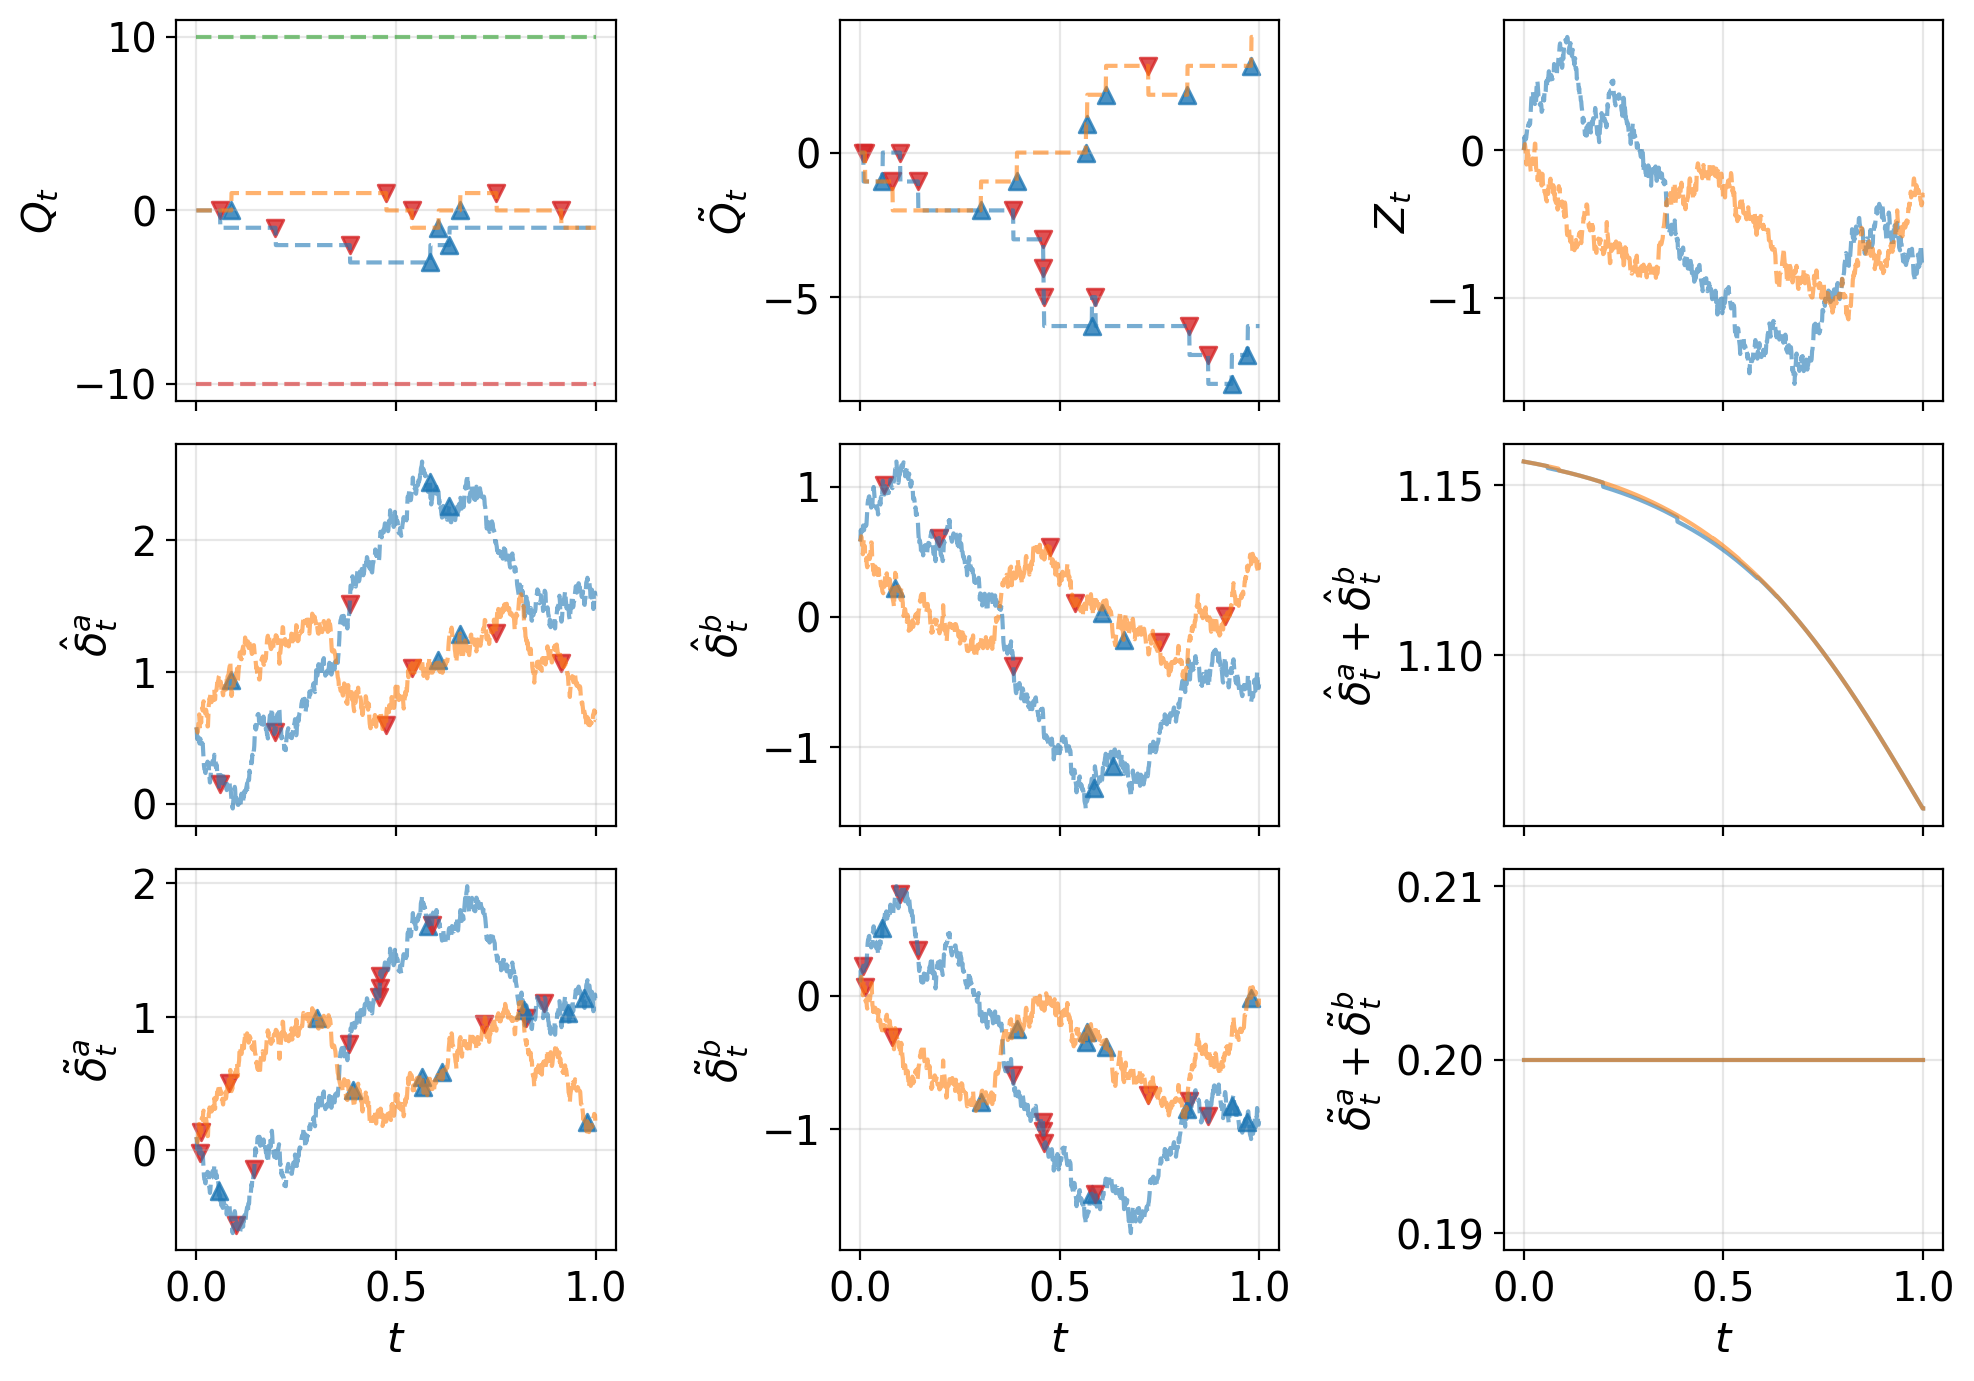

In [21]:
# since final depths never calculated
nmin = 7
nmax = nmin + 2
deltas_a[:,-1] = deltas_a[:,-2]
deltas_b[:,-1] = deltas_b[:,-2]
tildes_a[:,-1] = tildes_a[:,-2]
tildes_b[:,-1] = tildes_b[:,-2]

print("Terminal Q mean = "+str(np.round(np.mean(Q[:,-1]),4))+"              Terminal Q sd = "+str(np.round(np.std(Q[:,-1]),4)))
print("Terminal $\tilde{Q}$ mean = "+str(np.round(np.mean(Q_tilde[:,-1]),4))+"              Terminal $\tilde{Q}$ sd = "+str(np.round(np.std(Q_tilde[:,-1]),4)))
print("Terminal X mean = "+str(np.round(np.mean(X[:,-1]),4))+"            Terminal X sd = "+str(np.round(np.std(X[:,-1]),4)))
print("Terminal PnL mean = "+str(np.round(np.mean(pnl[:]),4))+"           Terminal PnL sd = "+str(np.round(np.std(pnl[:]),4)))
print("Terminal objective mean = "+str(np.round(np.mean(objective[:]),4))+"     Terminal objective sd = "+str(np.round(np.std(objective[:]),4)))

print("$Q_{T}$ &"+str(np.round(np.mean(Q[:,-1]),4))+" & "+str(np.round(np.std(Q[:,-1]),4))+" \\\ ")
print("$\tilde{Q}_{T}$ &"+str(np.round(np.mean(Q_tilde[:,-1]),4))+" & "+str(np.round(np.std(Q_tilde[:,-1]),4))+" \\\ ") 
print("$\mathcal{J}$ &"+str(np.round(np.mean(objective[:]),4))+" & "+str(np.round(np.std(objective[:]),4))+" \\\ ")



fig, ax = plt.subplots(3, 3, figsize = (10,7), sharey=False, sharex=True)
ax[0,0].plot(time, np.transpose(Q[nmin:nmax,:]), '--', alpha = 0.6)
ax[0,0].plot(time, np.repeat(qmax, len(time)), '--', alpha = 0.6)
ax[0,0].plot(time, np.repeat(qmin, len(time)), '--', alpha = 0.6)
ax[0,1].plot(time, np.transpose(Q_tilde[nmin:nmax,:]), '--', alpha = 0.6)
ax[0,2].plot(time, np.transpose(Z[nmin:nmax,:]), '--', alpha = 0.6)


ax[1,0].plot(time, np.transpose(deltas_a[nmin:nmax,:]), '--', label=r'$\delta^{a}$', alpha = 0.6)
ax[1,1].plot(time, np.transpose(deltas_b[nmin:nmax,:]), '--', label=r'$\delta^{b}$', alpha = 0.6)
ax[1,2].plot(time, np.transpose(deltas_a[nmin:nmax,:]+deltas_b[nmin:nmax,:]), label='Reference spread', alpha = 0.6)

ax[2,0].plot(time, np.transpose(tildes_a[nmin:nmax,:]), '--', label=r'$\tilde{\delta}^{a}$', alpha = 0.6)
ax[2,1].plot(time, np.transpose(tildes_b[nmin:nmax,:]), '--', label=r'$\tilde{\delta}^{a}$', alpha = 0.6)
ax[2,2].plot(time, np.transpose(np.round(tildes_a[nmin:nmax,:]+tildes_b[nmin:nmax,:],3)), label='Competition spread', alpha = 0.6)

for i in np.arange(nmin,nmax,1):
    mm_bought = np.argwhere(np.diff(Q[i,:])==1)[:,0]
    mm_sold = np.argwhere(np.diff(Q[i,:])==-1)[:,0]
    ax[0,0].scatter(time[mm_bought], Q[i,mm_bought], marker = "^", color='tab:blue', alpha = 0.8)
    ax[0,0].scatter(time[mm_sold], Q[i,mm_sold], marker = "v", color='tab:red', alpha = 0.8)
    ax[1,0].scatter(time[mm_bought], deltas_a[i,mm_bought], marker = "^", color='tab:blue', alpha = 0.8)
    ax[1,0].scatter(time[mm_sold], deltas_a[i,mm_sold], marker = "v", color='tab:red', alpha = 0.8)
    ax[1,1].scatter(time[mm_bought], deltas_b[i,mm_bought], marker = "^", color='tab:blue', alpha = 0.8)
    ax[1,1].scatter(time[mm_sold], deltas_b[i,mm_sold], marker = "v", color='tab:red', alpha = 0.8)
    
    comp_bought = np.argwhere(np.diff(Q_tilde[i,:])==1)[:,0]
    comp_sold = np.argwhere(np.diff(Q_tilde[i,:])==-1)[:,0]
    
    ax[0,1].scatter(time[comp_bought], Q_tilde[i,comp_bought], marker = "^", color='tab:blue', alpha = 0.8)
    ax[0,1].scatter(time[comp_sold], Q_tilde[i,comp_sold], marker = "v", color='tab:red', alpha = 0.8)
    ax[2,0].scatter(time[comp_bought], tildes_a[i,comp_bought], marker = "^", color='tab:blue', alpha = 0.8)
    ax[2,0].scatter(time[comp_sold], tildes_a[i,comp_sold], marker = "v", color='tab:red', alpha = 0.8)
    ax[2,1].scatter(time[comp_bought], tildes_b[i,comp_bought], marker = "^", color='tab:blue', alpha = 0.8)
    ax[2,1].scatter(time[comp_sold], tildes_b[i,comp_sold], marker = "v", color='tab:red', alpha = 0.8)
    
    


#ax[0].set_title("Reference MM's inventory", **tnrfont)
#ax[1].set_title("Pooled competition's inventory", **tnrfont)
ax[2,0].set_xlabel(r'$t$', fontsize = fs)
ax[2,1].set_xlabel(r'$t$', fontsize = fs)
ax[2,2].set_xlabel(r'$t$', fontsize = fs)

ax[0,0].set_ylabel(r'$Q_t$', fontsize = fs)
ax[0,1].set_ylabel(r'$\tilde{Q}_t$', fontsize = fs)
ax[0,2].set_ylabel(r'$Z_t$', fontsize = fs)

ax[1,0].set_ylabel(r'$\hat\delta^{a}_t$', fontsize = fs)
ax[1,1].set_ylabel(r'$\hat\delta^{b}_t$', fontsize = fs)
ax[1,2].set_ylabel(r'$\hat\delta^{a}_t+\hat\delta^{b}_t$', fontsize = fs)

ax[2,0].set_ylabel(r'$\tilde{\delta}^{a}_t$', fontsize = fs)
ax[2,1].set_ylabel(r'$\tilde{\delta}^{b}_t$', fontsize = fs)
ax[2,2].set_ylabel(r'$\tilde{\delta}^{a}_t+\tilde{\delta}^{b}_t$', fontsize = fs)

plt.tight_layout()

for i in range(3):
    for j in range(3):
        ax[i,j].grid(alpha=0.3)

plt.savefig('figures/q_d_deltas_tildes_new.pdf', format="pdf", dpi=dpi)
plt.show()



In [22]:
deltas_a = np.round(deltas_a[:,:], 3) - eta
deltas_b = np.round(deltas_b[:,:], 3) - eta
tildes_a = np.round(tildes_a[:,:], 3) 
tildes_b = np.round(tildes_b[:,:], 3) 
S = np.round(S, 3)

In [23]:
for i in range(sims):
    webetter_b = np.argwhere(deltas_b[i,:] < tildes_b[i,:])
    if np.sum(webetter_b)>0:
        print('it =',i,' and sum = ',np.sum(webetter_b))

it = 916  and sum =  14312
it = 3596  and sum =  7404
it = 3825  and sum =  79184
it = 7081  and sum =  4028
it = 9183  and sum =  72782
it = 9577  and sum =  7885


In [24]:
for i in range(sims):
    webetter_a = np.argwhere(deltas_a[i,:] < tildes_a[i,:])
    if np.sum(webetter_a)>0:
        print('it =',i,' and sum = ',np.sum(webetter_a))

it = 583  and sum =  4635
it = 836  and sum =  685
it = 1710  and sum =  8680
it = 1974  and sum =  2345
it = 3579  and sum =  16695
it = 4148  and sum =  26597
it = 9140  and sum =  14105


simulation =  915


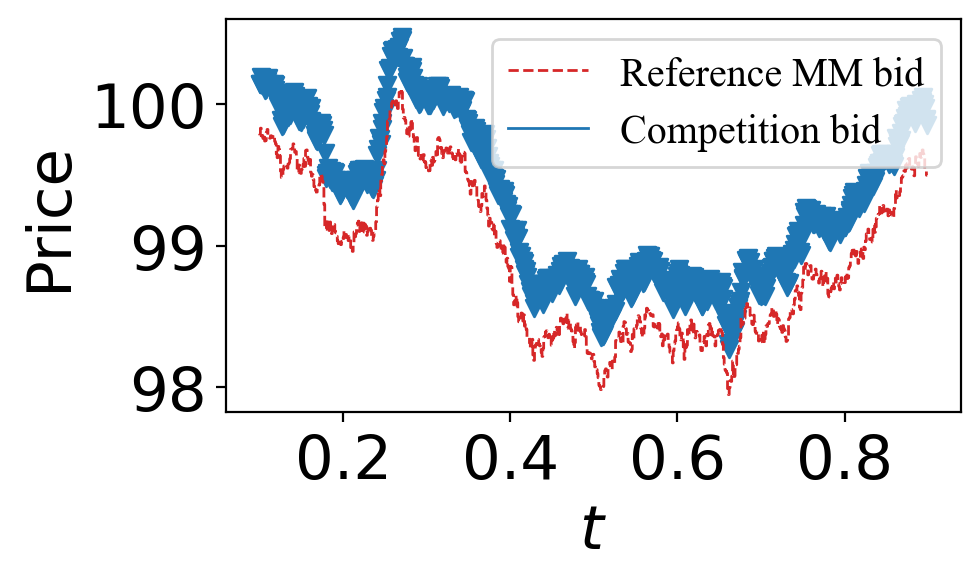

simulation =  916


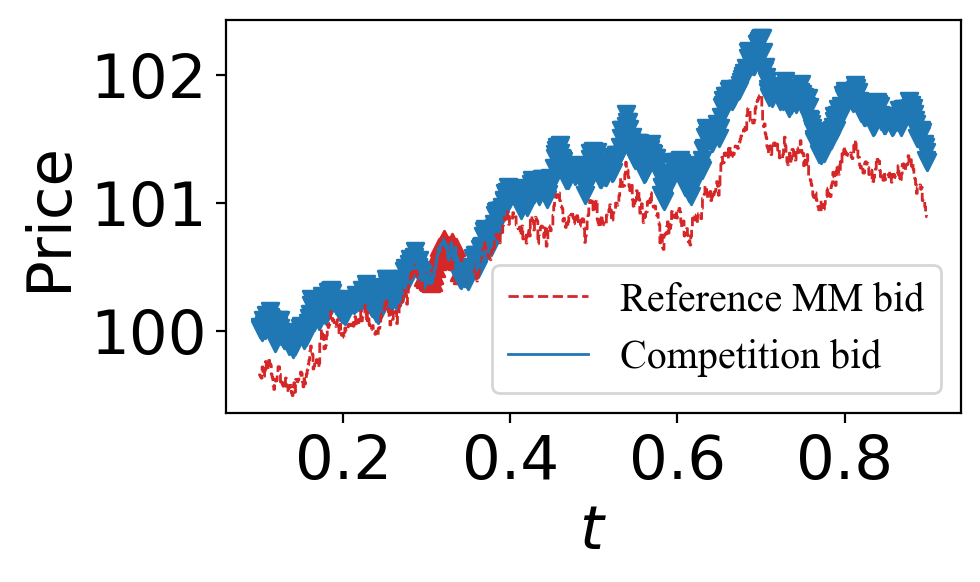

simulation =  917


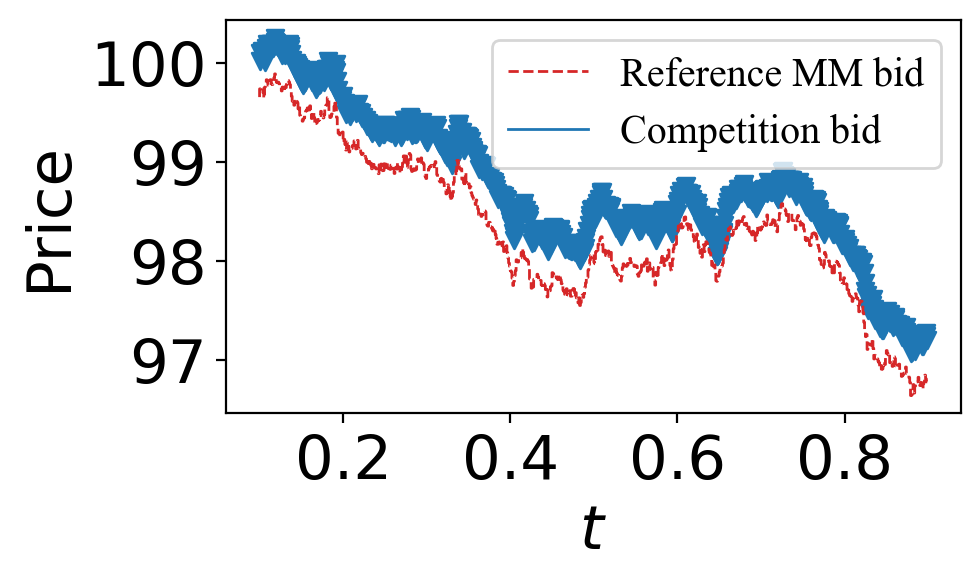

In [25]:
plotfrom=int(Nt*0.1)
plotto = int(Nt*0.9)

time_aux = time[plotfrom:plotto]
deltas_a_aux = deltas_a[:,plotfrom:plotto]
deltas_b_aux = deltas_b[:,plotfrom:plotto]
tildes_a_aux = tildes_a[:,plotfrom:plotto] 
tildes_b_aux = tildes_b[:,plotfrom:plotto] 
S_aux = S[:,plotfrom:plotto]

for i in range(3):
    sim = 915+i
    
    webetter_a = np.argwhere(deltas_a_aux[sim,:] < tildes_a_aux[sim,:])
    theybetter_a = np.argwhere(deltas_a_aux[sim,:] >= tildes_a_aux[sim,:])
    webetter_b = np.argwhere(deltas_b_aux[sim,:] < tildes_b_aux[sim,:])
    theybetter_b = np.argwhere(deltas_b_aux[sim,:] >= tildes_b_aux[sim,:])
    
    print('simulation = ',sim)

    fig, ax = plt.subplots(1, 1, figsize = (5,3), sharey=False, sharex=True)
    plt.scatter(time_aux[webetter_b[:,0]], S_aux[sim,webetter_b[:,0]] - deltas_b_aux[sim,webetter_b[:,0]], marker = "^", color='tab:red')
    plt.scatter(time_aux[theybetter_b[:,0]], S_aux[sim,theybetter_b[:,0]] - tildes_b_aux[sim,theybetter_b[:,0]], marker = "v", color='tab:blue')

    #plt.step(time_aux, S[sim,plotfrom:plotto], linewidth=0.6, label="Unaffected", color="gold")
    #plt.step(time_aux, S[sim,plotfrom:plotto]+deltas_a[sim,plotfrom:plotto], '--', linewidth=0.8, label="Ref Ask", color="darkgreen")
    plt.step(time_aux, S[sim,plotfrom:plotto]-deltas_b[sim,plotfrom:plotto], '--', linewidth=1, label="Reference MM bid", color="tab:red")
    #plt.step(time_aux, S[sim,plotfrom:plotto]+tildes_a[sim,plotfrom:plotto], linewidth=0.8, label="Comp Ask", color="lawngreen")
    plt.step(time_aux, S[sim,plotfrom:plotto]-tildes_b[sim,plotfrom:plotto], linewidth=1, label="Competition bid", color="tab:blue")
    plt.ticklabel_format(axis='y', useOffset=False)
    plt.xticks(fontsize = 22)
    plt.yticks(fontsize = 22)
    ax.set_ylabel("Price", fontsize = 22)
    ax.set_xlabel(r'$t$', fontsize = 22)
    #ax.set_title("Realisation of price processes", **tnrfont)
    ax.legend(prop={'family':fontnm})
    plt.tight_layout()
    #plt.savefig('figures/competition_for_TOB.pdf', format="pdf", dpi=dpi)
    plt.show()


In [26]:
fs = 17

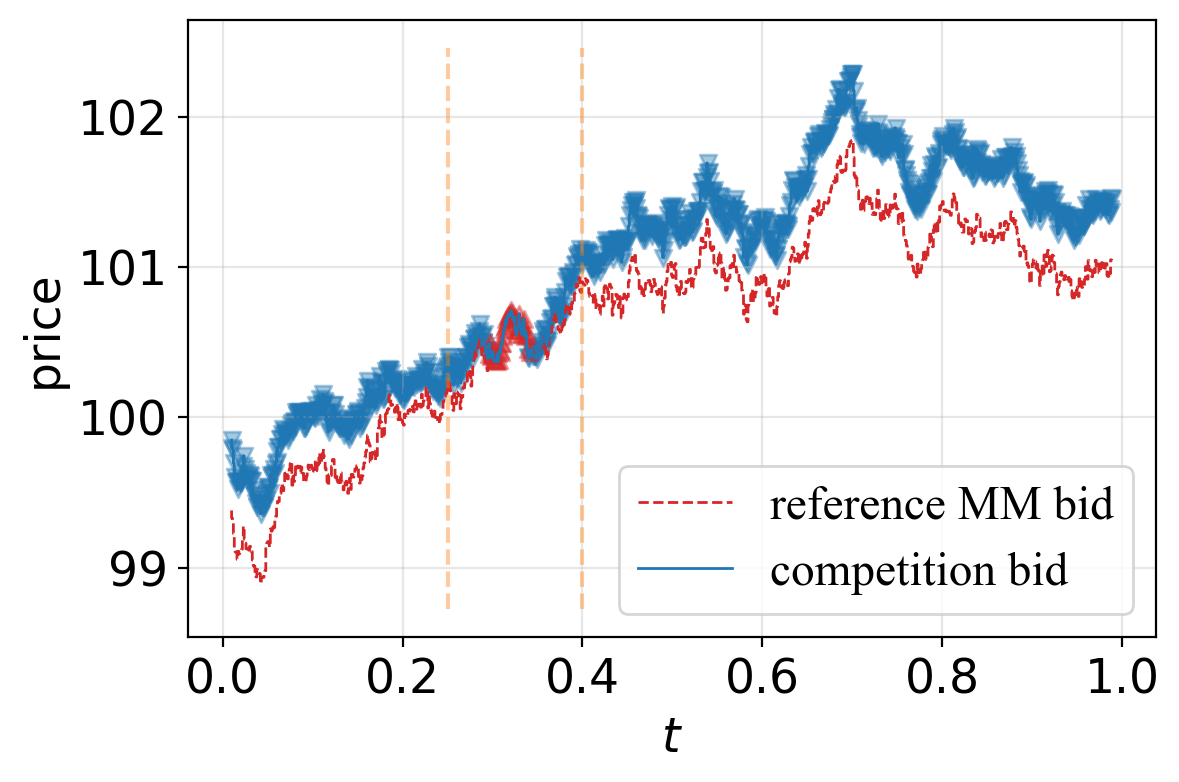

In [27]:
sim = 916
plotfrom=int(Nt*0.01)
plotto = int(Nt*0.99)

zoomed_plotfrom=int(Nt*0.25)
zoomed_plotto = int(Nt*0.40)

time_aux = time[plotfrom:plotto]
deltas_a_aux = deltas_a[:,plotfrom:plotto]
deltas_b_aux = deltas_b[:,plotfrom:plotto]
tildes_a_aux = tildes_a[:,plotfrom:plotto]
tildes_b_aux = tildes_b[:,plotfrom:plotto]
S_aux = S[:,plotfrom:plotto]


webetter_a = np.argwhere(deltas_a_aux[sim,:] < tildes_a_aux[sim,:])
theybetter_a = np.argwhere(deltas_a_aux[sim,:] >= tildes_a_aux[sim,:])
webetter_b = np.argwhere(deltas_b_aux[sim,:] < tildes_b_aux[sim,:])
theybetter_b = np.argwhere(deltas_b_aux[sim,:] >= tildes_b_aux[sim,:])



fig, ax = plt.subplots(1, 1, figsize = (6,4), sharey=False, sharex=True)
plt.scatter(time_aux[theybetter_b[:,0]], S_aux[sim,theybetter_b[:,0]] - tildes_b_aux[sim,theybetter_b[:,0]], marker = "v", color='tab:blue', alpha = 0.4)
plt.scatter(time_aux[webetter_b[:,0]], S_aux[sim,webetter_b[:,0]] - deltas_b_aux[sim,webetter_b[:,0]], marker = "^", color='tab:red', alpha = 0.4)

#plt.step(time_aux, S[sim,plotfrom:plotto], linewidth=0.6, label="Unaffected", color="gold")
#plt.step(time_aux, S[sim,plotfrom:plotto]+deltas_a[sim,plotfrom:plotto], '--', linewidth=0.8, label="Ref Ask", color="darkgreen")
plt.step(time_aux, S[sim,plotfrom:plotto]-deltas_b[sim,plotfrom:plotto], '--', linewidth=1, label="reference MM bid", color="tab:red")
#plt.step(time_aux, S[sim,plotfrom:plotto]+tildes_a[sim,plotfrom:plotto], linewidth=0.8, label="Comp Ask", color="lawngreen")
plt.step(time_aux, S[sim,plotfrom:plotto]-tildes_b[sim,plotfrom:plotto], linewidth=1, label="competition bid", color="tab:blue")

ymin = ax.get_ylim()[0]
ymax = ax.get_ylim()[1]

plt.vlines(x = time[zoomed_plotfrom], ymin = ymin, color = 'tab:orange', linestyles = '--', ymax = ymax, alpha = 0.4)
plt.vlines(x = time[zoomed_plotto], ymin = ymin, color = 'tab:orange', linestyles = '--', ymax = ymax, alpha = 0.4)

plt.ticklabel_format(axis='y', useOffset=False)
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
#plt.yticks(fontsize = fs, ticks = [99.50,100,100.50])
ax.set_ylabel("price", fontsize = fs)
ax.set_xlabel(r'$t$', fontsize = fs)
#ax.set_title("Realisation of price processes", **tnrfont)
ax.legend(prop={'family':fontnm, 'size': fs})
plt.tight_layout()
plt.grid(alpha=0.3)
plt.savefig('figures/competition_for_TOB_near_entire_day.pdf', format="pdf", dpi=dpi)
plt.show()

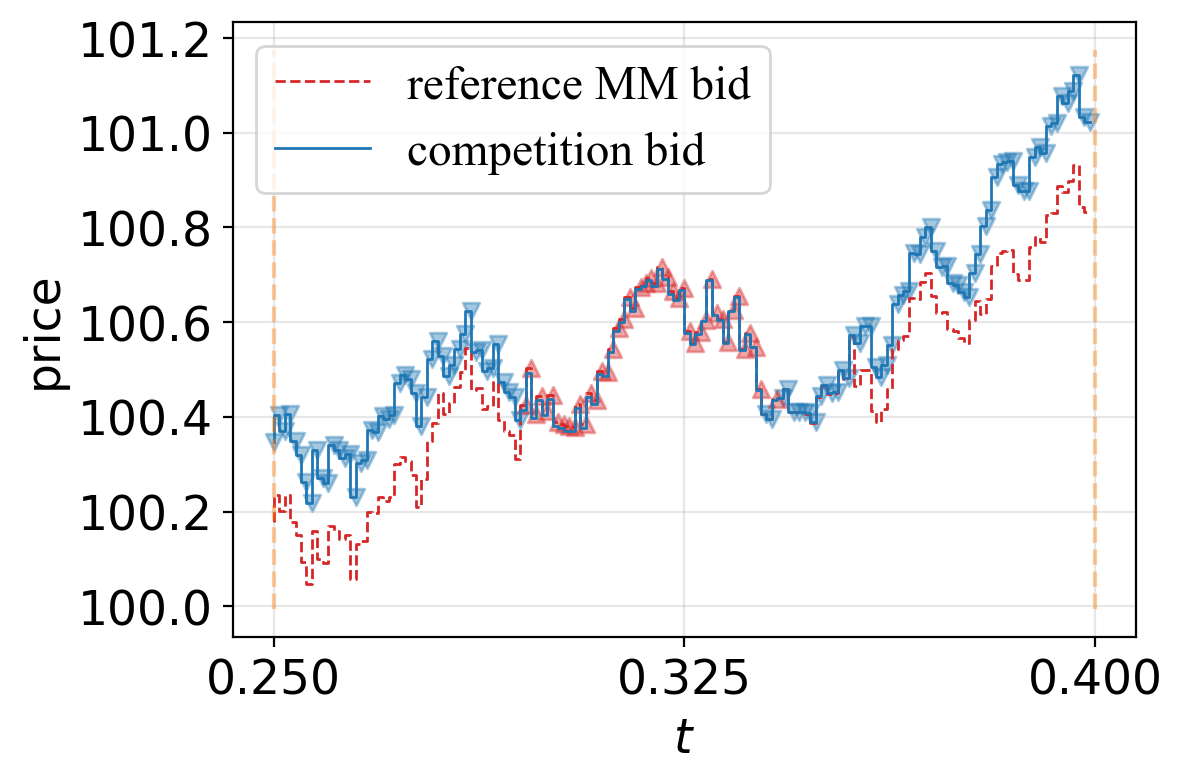

In [28]:
time_aux = time[zoomed_plotfrom:zoomed_plotto]
deltas_a_aux = deltas_a[:,zoomed_plotfrom:zoomed_plotto]
deltas_b_aux = deltas_b[:,zoomed_plotfrom:zoomed_plotto]
tildes_a_aux = tildes_a[:,zoomed_plotfrom:zoomed_plotto]
tildes_b_aux = tildes_b[:,zoomed_plotfrom:zoomed_plotto]
S_aux = S[:,zoomed_plotfrom:zoomed_plotto]


webetter_a = np.argwhere(deltas_a_aux[sim,:] < tildes_a_aux[sim,:])
theybetter_a = np.argwhere(deltas_a_aux[sim,:] >= tildes_a_aux[sim,:])
webetter_b = np.argwhere(deltas_b_aux[sim,:] < tildes_b_aux[sim,:])
theybetter_b = np.argwhere(deltas_b_aux[sim,:] >= tildes_b_aux[sim,:])


fig, ax = plt.subplots(1, 1, figsize = (6,4), sharey=False, sharex=True)
plt.scatter(time_aux[theybetter_b[:,0]], S_aux[sim,theybetter_b[:,0]] - tildes_b_aux[sim,theybetter_b[:,0]], marker = "v", color='tab:blue', alpha = 0.4)
plt.scatter(time_aux[webetter_b[:,0]], S_aux[sim,webetter_b[:,0]] - deltas_b_aux[sim,webetter_b[:,0]], marker = "^", color='tab:red', alpha = 0.4)
plt.step(time_aux, S[sim,zoomed_plotfrom:zoomed_plotto]-deltas_b[sim,zoomed_plotfrom:zoomed_plotto], '--', linewidth=1, label="reference MM bid", color="tab:red")
plt.step(time_aux, S[sim,zoomed_plotfrom:zoomed_plotto]-tildes_b[sim,zoomed_plotfrom:zoomed_plotto], linewidth=1, label="competition bid", color="tab:blue")
plt.ticklabel_format(axis='y', useOffset=False)
plt.xticks(fontsize = fs, ticks = [zoomed_plotfrom/Nt, (zoomed_plotfrom+zoomed_plotto)/(2*Nt), zoomed_plotto/Nt])
plt.yticks(fontsize = fs)

ax.set_ylabel("price", fontsize = fs)
ax.set_xlabel(r'$t$', fontsize = fs)
ymin = ax.get_ylim()[0]
ymax = ax.get_ylim()[1]

plt.vlines(x = time[zoomed_plotfrom], ymin = ymin, color = 'tab:orange', linestyles = '--', ymax = ymax, alpha = 0.4)
plt.vlines(x = time[zoomed_plotto], ymin = ymin, color = 'tab:orange', linestyles = '--', ymax = ymax, alpha = 0.4)

#ax.set_title("Realisation of price processes", **tnrfont)
ax.legend(prop={'family':fontnm, 'size': fs})
plt.tight_layout()
plt.grid(alpha=0.3)
plt.savefig('figures/competition_for_TOB_short_snapshot.pdf', format="pdf", dpi=dpi)
plt.show()



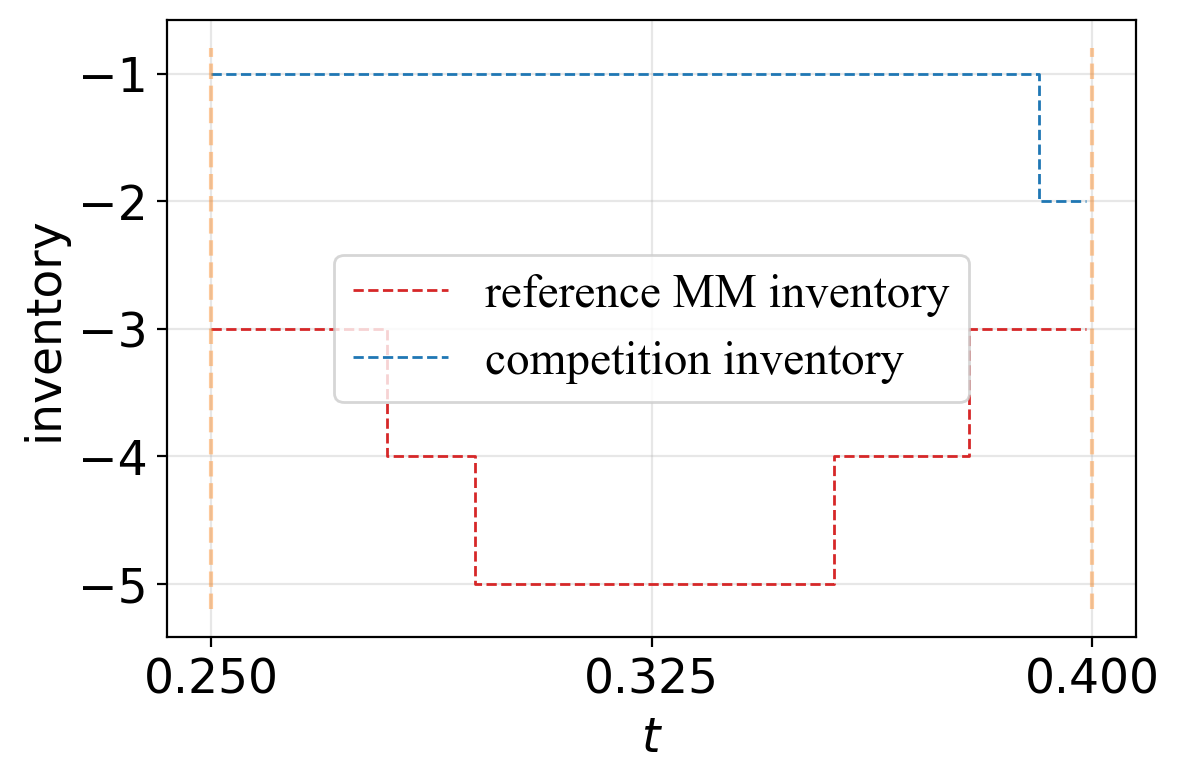

In [29]:

fig, ax = plt.subplots(1, 1, figsize = (6,4), sharey=False, sharex=True)
plt.step(time_aux, Q[sim,zoomed_plotfrom:zoomed_plotto], '--', linewidth=1, label="reference MM inventory", color="tab:red")
plt.step(time_aux, Q_tilde[sim,zoomed_plotfrom:zoomed_plotto], '--', linewidth=1, label="competition inventory", color="tab:blue")
plt.ticklabel_format(axis='y', useOffset=False)
plt.xticks(fontsize = fs, ticks = [zoomed_plotfrom/Nt, (zoomed_plotfrom+zoomed_plotto)/(2*Nt), zoomed_plotto/Nt])
plt.yticks(fontsize = fs)
ax.set_ylabel("inventory", fontsize = fs)
ax.set_xlabel(r'$t$', fontsize = fs)
ymin = ax.get_ylim()[0]
ymax = ax.get_ylim()[1]

plt.vlines(x = time[zoomed_plotfrom], ymin = ymin, color = 'tab:orange', linestyles = '--', ymax = ymax, alpha = 0.4)
plt.vlines(x = time[zoomed_plotto], ymin = ymin, color = 'tab:orange', linestyles = '--', ymax = ymax, alpha = 0.4)

#ax.set_title("Realisation of price processes", **tnrfont)
ax.legend(prop={'family':fontnm, 'size': fs})
plt.tight_layout()
plt.grid(alpha=0.3)
plt.savefig('figures/competition_for_TOB_short_snapshot_inventory.pdf', format="pdf", dpi=dpi)
plt.show()



# Euler scheme

In [30]:
rng = np.random.default_rng(seed=seedno)

In [31]:
def euler_scheme(steps):
    h = T/steps
    g = np.zeros((steps, qmax-qmin+1))
    for iq, q in enumerate(all_inventories):
        g[-1, iq] = ((a-b)/2)*q - (gamma-beta/2)*(q**2)
    for it in np.linspace(1,steps-1,steps-1):
        it = int(it)
        for iq, q in enumerate(all_inventories):
            if not iq==0 and not iq==qmax-qmin:
                c_star_a = np.maximum(1/kappa - g[-it, iq-1] + g[-it, iq], a - beta/2)
                c_star_b = np.maximum(1/kappa - g[-it, iq+1] + g[-it, iq], b - beta/2)
                g[-it-1, iq] = g[-it, iq] + h*(-phi*(q**2) 
                                             + (lambda_a-lambda_b)*beta*q 
                                             + lambda_a*np.exp(-kappa*(c_star_a + beta/2 - a))*(c_star_a + g[-it,iq-1] - g[-it,iq])
                                             + lambda_b*np.exp(-kappa*(c_star_b + beta/2 - b))*(c_star_b + g[-it,iq+1] - g[-it,iq]))
            if iq==0:
                c_star_b = np.maximum(1/kappa - g[-it, iq+1] + g[-it, iq], b - beta/2)
                g[-it-1, iq] = g[-it, iq] + h*(-phi*(q**2) 
                                             + (lambda_a-lambda_b)*beta*q 
                                             + lambda_b*np.exp(-kappa*(c_star_b + beta/2 - b))*(c_star_b + g[-it,iq+1] - g[-it,iq]))
            if iq==qmax-qmin:
                c_star_a = np.maximum(1/kappa - g[-it, iq-1] + g[-it, iq], a - beta/2)
                g[-it-1, iq] = g[-it, iq] + h*(-phi*(q**2) 
                                             + (lambda_a-lambda_b)*beta*q 
                                             + lambda_a*np.exp(-kappa*(c_star_a + beta/2 - a))*(c_star_a + g[-it,iq-1] - g[-it,iq]))
    return g

In [32]:
def _calculate_deltas_euler(t, q, q_tilde, z, gt, gt_q_minus, gt_q_plus, take_maximum = True):    
    
    c_hat_a = 1/kappa - gt_q_minus + gt
    c_hat_b = 1/kappa - gt_q_plus + gt
    
    if take_maximum:
        c_a = np.maximum(c_hat_a, a - beta/2)
        c_b = np.maximum(c_hat_b, b - beta/2)
    else:
        c_a = c_hat_a
        c_b = c_hat_b
    
    delta_a = c_a - beta*q_tilde - z + beta/2
    delta_b = c_b + beta*q_tilde + z + beta/2

    return delta_a, delta_b

In [33]:
Nt = 1000
sims = 10_000
dt = T/Nt
euler_steps= 1_000_000

X = np.zeros((sims,Nt+1))
Q = np.zeros((sims,Nt+1))
Q_tilde = np.zeros((sims,Nt+1))
S = np.zeros((sims,Nt+1))
Z = np.zeros((sims,Nt+1))
pnl_euler = np.zeros(sims)
intQ = np.zeros(sims)
objective_euler = np.zeros(sims)

deltas_a = np.zeros((sims, Nt+1))
deltas_b = np.zeros((sims, Nt+1))
tildes_a = np.zeros((sims, Nt+1))
tildes_b = np.zeros((sims, Nt+1))

arrivaltimes_a = np.zeros((sims, Nt+1))
arrivaltimes_b = np.zeros((sims, Nt+1))

S[:,0] = S0

time = np.linspace(0, T, Nt+1)

In [34]:
g = euler_scheme(steps=euler_steps)

all_inventories_list = list(all_inventories)
all_inventories_list = [ round(elem, 2) for elem in all_inventories]

In [35]:
for it,t in enumerate(time[:-1]):   
    
    gt_all_q = g[int(it*(euler_steps/Nt)), :]
    G = np.zeros(sims)
    G_down = np.zeros(sims)
    G_up = np.zeros(sims)
    for sim, q in enumerate(Q[:,it]):
        G[sim] = gt_all_q[all_inventories_list.index(q)]
        if not q==qmin: # if true, doesn't matter since these values won't be used
            G_down[sim] = gt_all_q[all_inventories_list.index(q-1)]
        if not q==qmax:
            G_up[sim] = gt_all_q[all_inventories_list.index(q+1)]
        
    delta_a, delta_b = _calculate_deltas_euler(t, Q[:,it], Q_tilde[:,it], Z[:,it], gt=G, gt_q_minus=G_down, gt_q_plus=G_up)
    
    deltas_a[:, it] = delta_a[:]
    deltas_b[:, it] = delta_b[:]
    
    aux_normal = rng.normal(0, 1, size= (sims,))
    Z[:,it+1] = Z[:,it] + np.sqrt(T/Nt) * aux_normal

    aux_normal = rng.normal(0, 1, size= (sims,))
    S[:,it+1] = S[:,it] + sigma *  np.sqrt(T/Nt) * aux_normal
    
    arrival_a, arrival_b = get_arrival(sims, dt, lambda_a, lambda_b)
    arrivaltimes_a[:,it] = arrival_a*t
    arrivaltimes_b[:,it] = arrival_b*t
    
    fill_a = rng.uniform(size=(sims,))
    fill_b = rng.uniform(size=(sims,))
    
    delta_tilde_a = a - beta * Q_tilde[:,it] - Z[:,it]
    delta_tilde_b = b + beta * Q_tilde[:,it] + Z[:,it]
    tildes_a[:,it] = delta_tilde_a[:]
    tildes_b[:,it] = delta_tilde_b[:]
    
    prob_a = np.minimum(np.exp(-kappa*(delta_a - delta_tilde_a)),1)
    prob_b = np.minimum(np.exp(-kappa*(delta_b - delta_tilde_b)),1)
    
    filled_trade_a = (fill_a <= prob_a) * (Q[:,it]!=(qmin+1))
    filled_trade_b = (fill_b <= prob_b) * (Q[:,it]!=(qmax-1))
    
    
    Q[:,it+1] = Q[:,it] - filled_trade_a*arrival_a + filled_trade_b*arrival_b
    Q_tilde[:,it+1] = Q_tilde[:,it] - (1-filled_trade_a)*arrival_a + (1-filled_trade_b)*arrival_b
    
    X[:,it+1] = X[:,it] + filled_trade_a*arrival_a*(S[:,it] + delta_a) - filled_trade_b*arrival_b*(S[:,it] - delta_b)

pnl_euler[:] = X[:,-1] + Q[:,-1]*(S[:,-1]+(a-b)/2 - beta*Q_tilde[:,-1] - Z[:,-1])
for s in range(1, sims):
    intQ[s] = np.sum(Q[s,:]**2)/Nt
objective_euler[:] = pnl[:] - a*Q[:,-1]**2 - phi*intQ[:] 

Terminal Q mean = -0.0069              Terminal Q sd = 2.0037
Terminal $	ilde{Q}$ mean = -0.0439              Terminal $	ilde{Q} sd = 3.62
Terminal X mean = 5.0532            Terminal X sd = 200.4288
Terminal PnL mean = 4.2632           Terminal PnL sd = 2.5367
Terminal objective mean = 3.6362     Terminal objective sd = 2.5693
$Q_{T}$ &-0.0069 & 2.0037 \\ 
$	ilde{Q}_{T}$ &-0.0439 & 3.62 \\ 
$\mathcal{J}$ &3.6362 & 2.5693 \\ 


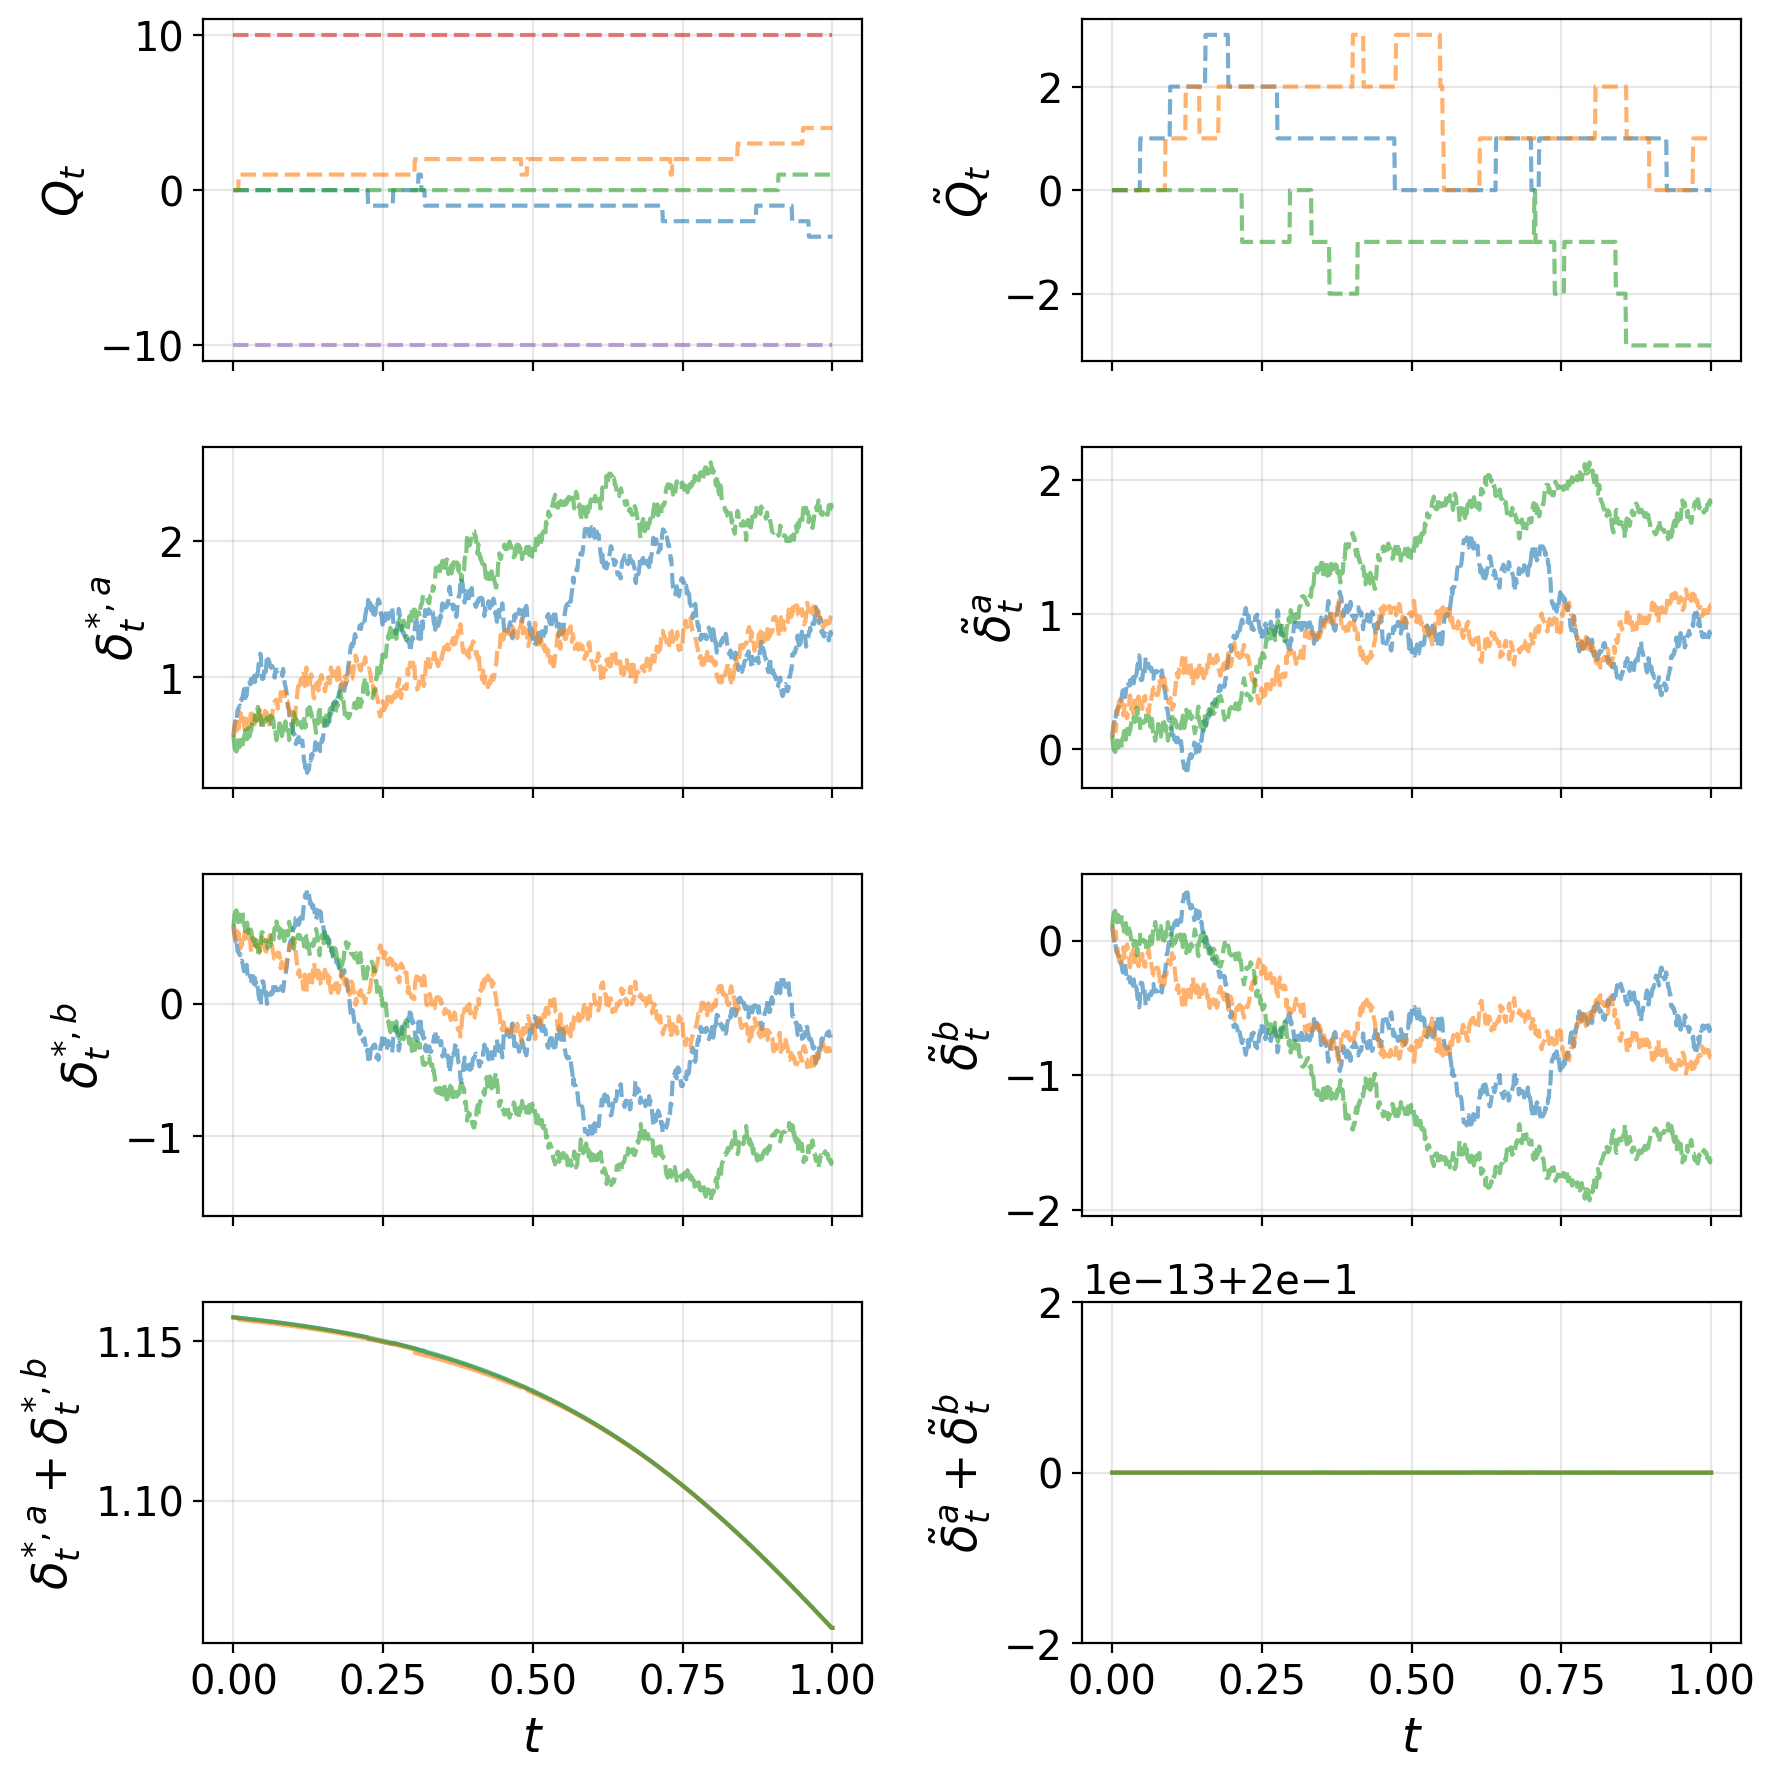

In [36]:
# since final depths never calculated
nmin = 45
nmax = 48
deltas_a[:,-1] = deltas_a[:,-2]
deltas_b[:,-1] = deltas_b[:,-2]
tildes_a[:,-1] = tildes_a[:,-2]
tildes_b[:,-1] = tildes_b[:,-2]

print("Terminal Q mean = "+str(np.round(np.mean(Q[:,-1]),4))+"              Terminal Q sd = "+str(np.round(np.std(Q[:,-1]),4)))
print("Terminal $\tilde{Q}$ mean = "+str(np.round(np.mean(Q_tilde[:,-1]),4))+"              Terminal $\tilde{Q} sd = "+str(np.round(np.std(Q_tilde[:,-1]),4)))
print("Terminal X mean = "+str(np.round(np.mean(X[:,-1]),4))+"            Terminal X sd = "+str(np.round(np.std(X[:,-1]),4)))
print("Terminal PnL mean = "+str(np.round(np.mean(pnl[:]),4))+"           Terminal PnL sd = "+str(np.round(np.std(pnl[:]),4)))
print("Terminal objective mean = "+str(np.round(np.mean(objective[:]),4))+"     Terminal objective sd = "+str(np.round(np.std(objective[:]),4)))

print("$Q_{T}$ &"+str(np.round(np.mean(Q[:,-1]),4))+" & "+str(np.round(np.std(Q[:,-1]),4))+" \\\ ")
print("$\tilde{Q}_{T}$ &"+str(np.round(np.mean(Q_tilde[:,-1]),4))+" & "+str(np.round(np.std(Q_tilde[:,-1]),4))+" \\\ ") 
print("$\mathcal{J}$ &"+str(np.round(np.mean(objective[:]),4))+" & "+str(np.round(np.std(objective[:]),4))+" \\\ ")

fig, ax = plt.subplots(4, 2, figsize = (9,9), sharey=False, sharex=True)
ax[0,0].plot(time, np.transpose(Q[nmin:nmax,:]), '--', alpha = 0.6)
ax[0,1].plot(time, np.transpose(Q_tilde[nmin:nmax,:]), '--', alpha = 0.6)
ax[0,0].plot(time, np.repeat(qmax, len(time)), '--', alpha = 0.6)
ax[0,0].plot(time, np.repeat(qmin, len(time)), '--', alpha = 0.6)
ax[1,0].plot(time, np.transpose(deltas_a[nmin:nmax,:]), '--', label=r'$\delta^{a}$', alpha = 0.6)
ax[1,1].plot(time, np.transpose(tildes_a[nmin:nmax,:]), '--', label=r'$\tilde{\delta}^{a}$', alpha = 0.6)
ax[2,0].plot(time, np.transpose(deltas_b[nmin:nmax,:]), '--', label=r'$\delta^{b}$', alpha = 0.6)
ax[2,1].plot(time, np.transpose(tildes_b[nmin:nmax,:]), '--', label=r'$\tilde{\delta}^{a}$', alpha = 0.6)
ax[3,0].plot(time, np.transpose(deltas_a[nmin:nmax,:]+deltas_b[nmin:nmax,:]), label='Reference spread', alpha = 0.6)
ax[3,1].plot(time, np.transpose(tildes_a[nmin:nmax,:]+tildes_b[nmin:nmax,:]), label='Competition spread', alpha = 0.6)
#ax[0].set_title("Reference MM's inventory", **tnrfont)
#ax[1].set_title("Pooled competition's inventory", **tnrfont)
ax[3,0].set_xlabel(r'$t$', fontsize = fs)
ax[3,1].set_xlabel(r'$t$', fontsize = fs)
ax[0,0].set_ylabel(r'$Q_t$', fontsize = fs)
ax[0,1].set_ylabel(r'$\tilde{Q}_t$', fontsize = fs)
ax[1,0].set_ylabel(r'$\delta^{*,a}_t$', fontsize = fs)
ax[1,1].set_ylabel(r'$\tilde{\delta}^{a}_t$', fontsize = fs)
ax[2,0].set_ylabel(r'$\delta^{*,b}_t$', fontsize = fs)
ax[2,1].set_ylabel(r'$\tilde{\delta}^{b}_t$', fontsize = fs)
ax[3,0].set_ylabel(r'$\delta^{*,a}_t+\delta^{*,b}_t$', fontsize = fs)
ax[3,1].set_ylabel(r'$\tilde{\delta}^{a}_t+\tilde{\delta}^{b}_t$', fontsize = fs)
plt.tight_layout()

for i in range(4):
    for j in range(2):
        ax[i,j].grid(alpha=0.3)

plt.savefig('figures/q_d_deltas_tildes_euler.pdf', format="pdf", dpi=dpi)
plt.show()



In [37]:
deltas_a = np.round(deltas_a[:,:], 3) - eta
deltas_b = np.round(deltas_b[:,:], 3) - eta
tildes_a = np.round(tildes_a[:,:], 3) 
tildes_b = np.round(tildes_b[:,:], 3) 
S = np.round(S, 3)

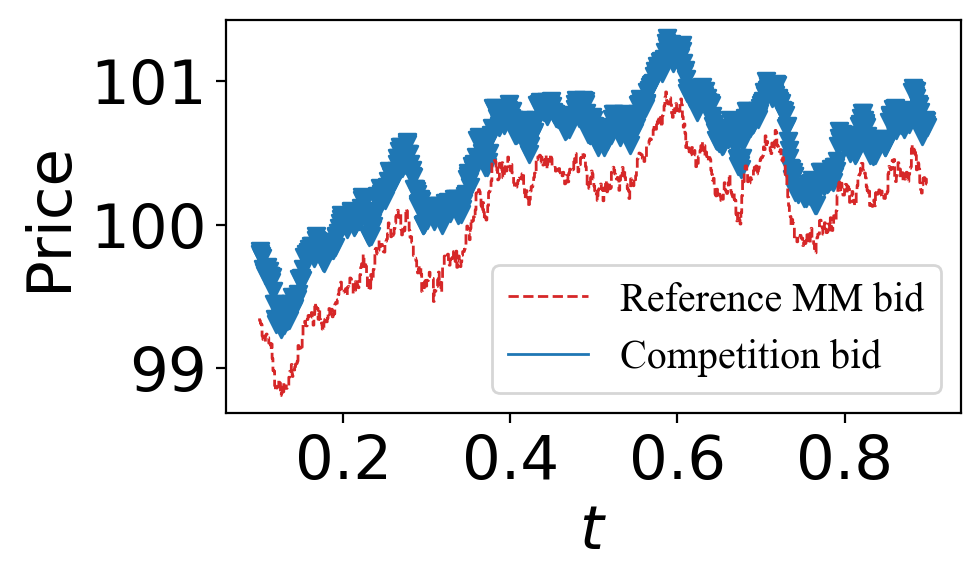

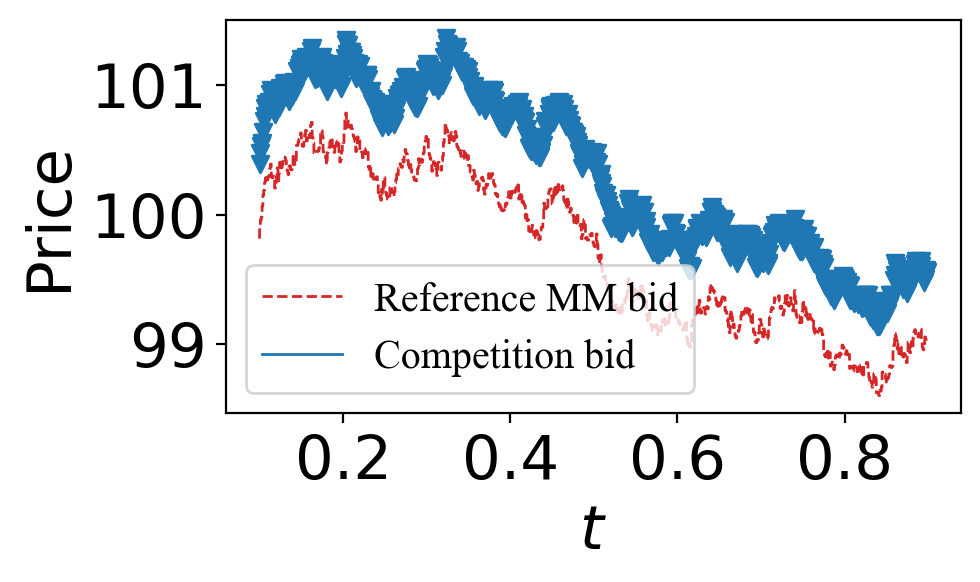

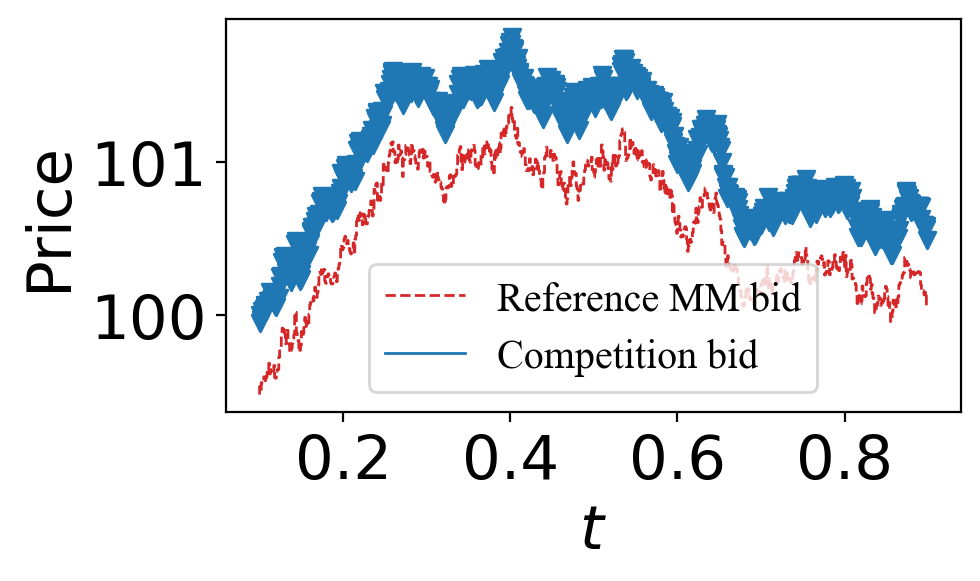

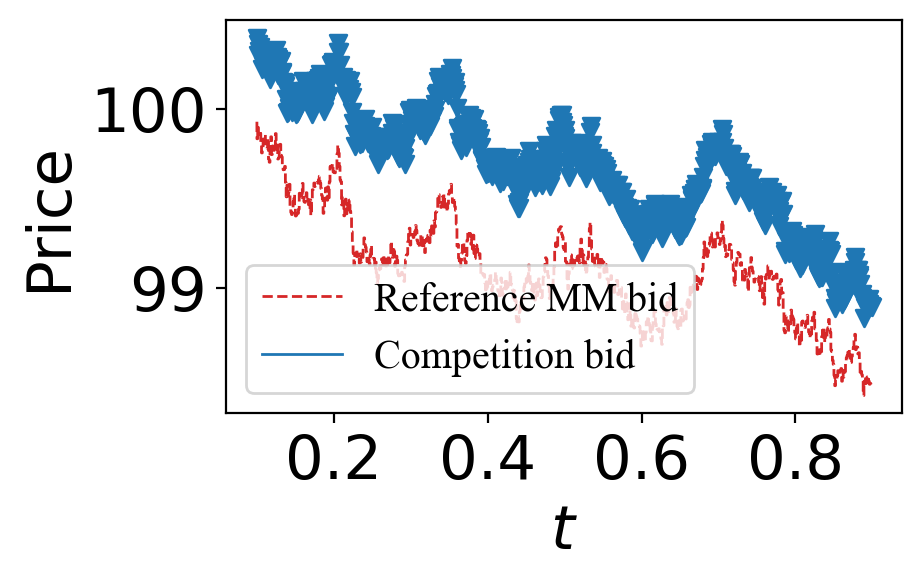

In [38]:
for i in range(4):
    sim = 45+i
    plotfrom=int(Nt*0.1)
    plotto = int(Nt*0.9)

    time_aux = time[plotfrom:plotto]
    deltas_a_aux = deltas_a[:,plotfrom:plotto]
    deltas_b_aux = deltas_b[:,plotfrom:plotto]
    tildes_a_aux = tildes_a[:,plotfrom:plotto] 
    tildes_b_aux = tildes_b[:,plotfrom:plotto] 
    S_aux = S[:,plotfrom:plotto]


    webetter_a = np.argwhere(deltas_a_aux[sim,:] < tildes_a_aux[sim,:])
    theybetter_a = np.argwhere(deltas_a_aux[sim,:] >= tildes_a_aux[sim,:])
    webetter_b = np.argwhere(deltas_b_aux[sim,:] < tildes_b_aux[sim,:])
    theybetter_b = np.argwhere(deltas_b_aux[sim,:] >= tildes_b_aux[sim,:])



    fig, ax = plt.subplots(1, 1, figsize = (5,3), sharey=False, sharex=True)
    plt.scatter(time_aux[webetter_b[:,0]], S_aux[sim,webetter_b[:,0]] - deltas_b_aux[sim,webetter_b[:,0]], marker = "^", color='tab:red')
    plt.scatter(time_aux[theybetter_b[:,0]], S_aux[sim,theybetter_b[:,0]] - tildes_b_aux[sim,theybetter_b[:,0]], marker = "v", color='tab:blue')

    #plt.step(time_aux, S[sim,plotfrom:plotto], linewidth=0.6, label="Unaffected", color="gold")
    #plt.step(time_aux, S[sim,plotfrom:plotto]+deltas_a[sim,plotfrom:plotto], '--', linewidth=0.8, label="Ref Ask", color="darkgreen")
    plt.step(time_aux, S[sim,plotfrom:plotto]-deltas_b[sim,plotfrom:plotto], '--', linewidth=1, label="Reference MM bid", color="tab:red")
    #plt.step(time_aux, S[sim,plotfrom:plotto]+tildes_a[sim,plotfrom:plotto], linewidth=0.8, label="Comp Ask", color="lawngreen")
    plt.step(time_aux, S[sim,plotfrom:plotto]-tildes_b[sim,plotfrom:plotto], linewidth=1, label="Competition bid", color="tab:blue")
    plt.ticklabel_format(axis='y', useOffset=False)
    plt.xticks(fontsize = 22)
    plt.yticks(fontsize = 22)
    ax.set_ylabel("Price", fontsize = 22)
    ax.set_xlabel(r'$t$', fontsize = 22)
    #ax.set_title("Realisation of price processes", **tnrfont)
    ax.legend(prop={'family':fontnm})
    plt.tight_layout()
    plt.savefig('figures/competition_for_TOB_euler.pdf', format="pdf", dpi=dpi)
    plt.show()


In [39]:
import pandas as pd
import seaborn as sns

/Applications/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


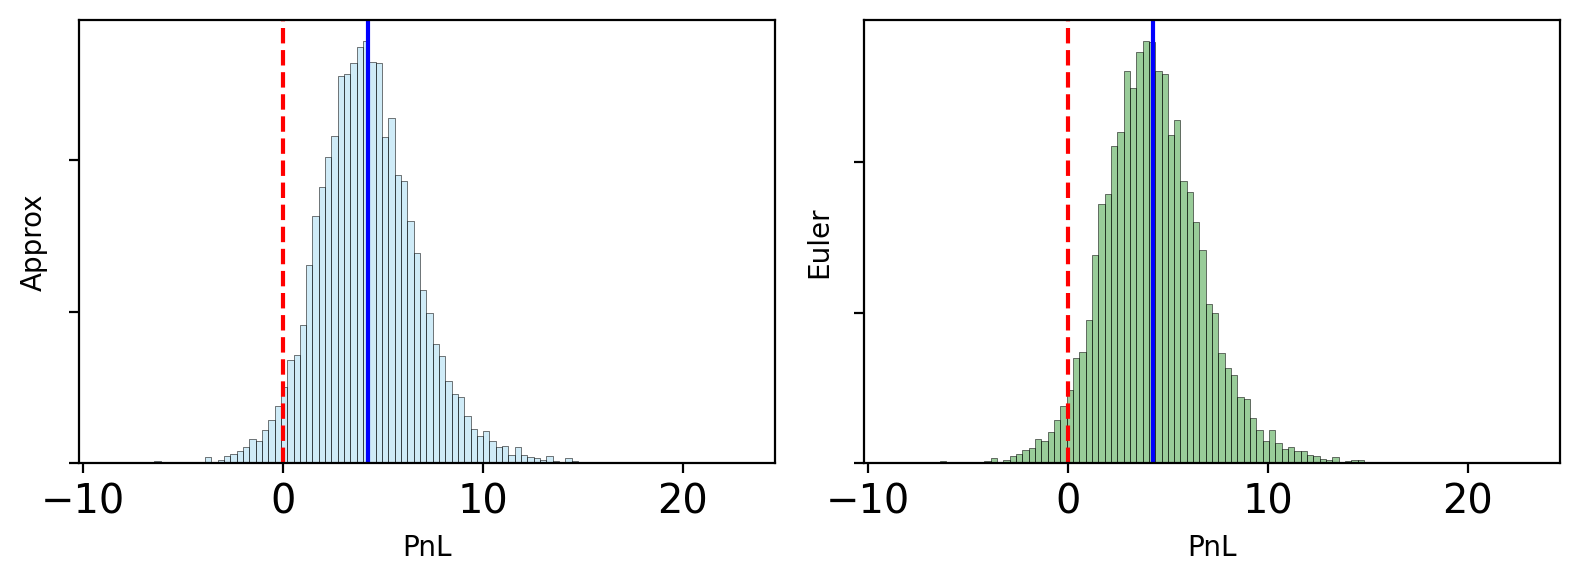

In [40]:
data = np.zeros((sims,2))
data[:,0] = pnl[:]
data[:,1] = pnl_euler[:]

df = pd.DataFrame(data, columns = ['Approx', 'Euler'])

fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8,3))

sns.histplot(data=df, x="Approx", bins = 100, kde=False, color="skyblue", ax=axs[0], alpha =0.4)
axs[0].axvline(0,linestyle = '--', color='red')
axs[0].axvline(df.Approx.mean(), color='blue')
axs[0].set_xlabel('PnL')
axs[0].set_ylabel('Approx')

sns.histplot(data=df, x="Euler", bins = 100, kde=False, color="green", ax=axs[1], alpha =0.4)
axs[1].axvline(0,linestyle = '--', color='red')
axs[1].axvline(df.Euler.mean(), color='blue')
axs[1].set_xlabel('PnL')
axs[1].set_ylabel('Euler')

axs[0].set_yticklabels([])
axs[1].set_yticklabels([])

plt.tight_layout()

#plt.savefig('figures/histograms_pnl.pdf', format="pdf", dpi=dpi)

plt.show()

In [41]:
print('APPROX: ', np.mean(pnl), np.std(pnl))
print('EULER: ', np.mean(pnl_euler), np.std(pnl_euler))

APPROX:  4.26316104842727 2.5367332718570506
EULER:  4.256973895442946 2.522374137579645


In [42]:
(np.mean(objective_euler) - np.mean(objective) ) / np.mean(objective)

0.005774676239117749

In [43]:
print('APPROX: ', np.mean(objective), np.std(objective))
print('EULER: ', np.mean(objective_euler), np.std(objective_euler))

APPROX:  3.63622809842727 2.5692584374634486
EULER:  3.65722613842727 2.564969337110689


In [44]:
difference = pnl[:] - pnl_euler[:]

In [45]:
np.mean(difference), np.std(difference)

(0.006187152984324534, 0.201242195554123)

In [46]:
import scipy as scipy

In [47]:
scipy.stats.ttest_rel(df['Approx'],df['Euler'])

TtestResult(statistic=3.0743272313768175, pvalue=0.0021154648273668786, df=9999)

/Applications/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


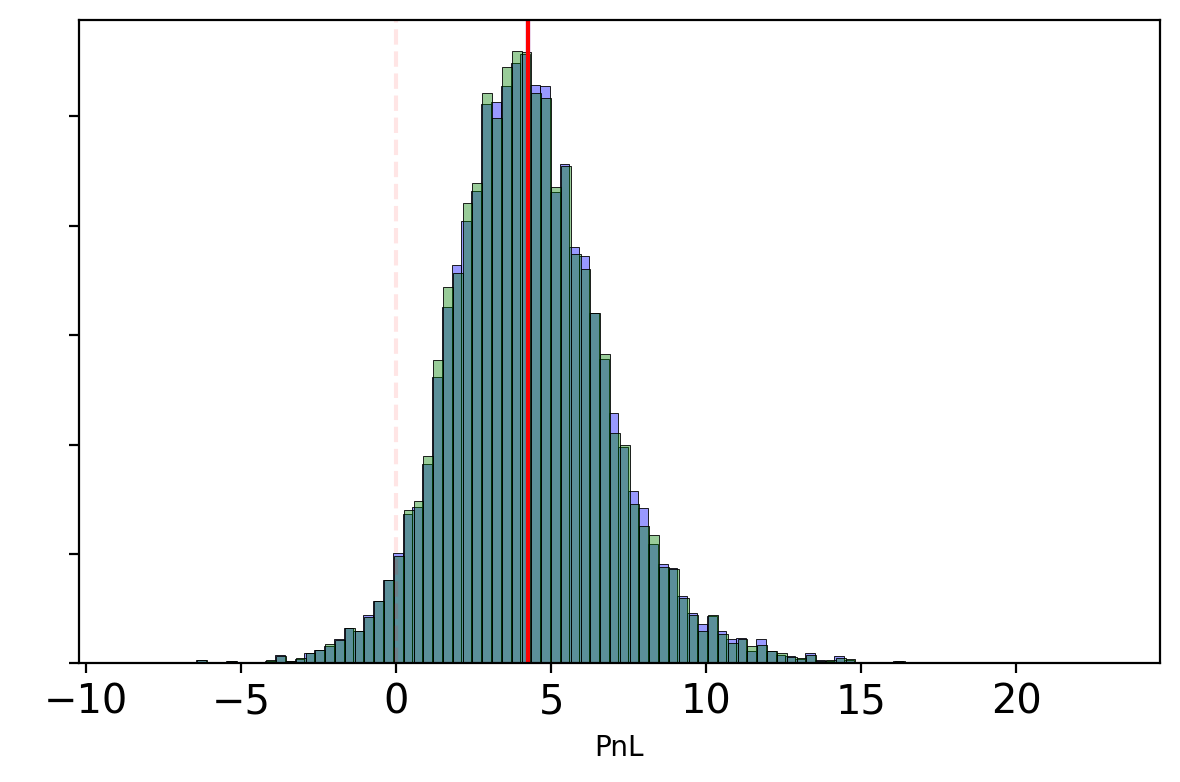

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

sns.histplot(data=df, x="Approx", bins = 100, kde=False, color="blue", ax=ax, alpha =0.4)
ax.axvline(df.Approx.mean(), color='blue')
sns.histplot(data=df, x="Euler", bins = 100, kde=False, color="green", ax=ax, alpha =0.4)
ax.axvline(df.Euler.mean(), color='red')
ax.set_xlabel('PnL')
ax.set_ylabel(' ')



ax.axvline(0,linestyle = '--', color='red',alpha = 0.1)

ax.set_yticklabels([])
plt.tight_layout()

#plt.savefig('figures/histograms_pnl.pdf', format="pdf", dpi=dpi)

plt.show()